In [43]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from sklearn import metrics

from sklearn.linear_model import LinearRegression

import warnings

import datetime
from datetime import timedelta, time
import statistics

import matplotlib.dates as mdates
from scipy.stats import pearsonr
%matplotlib inline

from prophet import Prophet

import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator  #must use this one for training with TimeSeriesGenerator
%matplotlib inline

In [44]:
data = pd.read_csv("/kaggle/input/consolidado/consolidado.csv", sep=";")

In [45]:
#Se filtran los clientes que tienen información completa del 99% en adelante
clientes = ["DATOSCLIENTE1.csv","DATOSCLIENTE2.csv","DATOSCLIENTE3.csv","DATOSCLIENTE4.csv",
            "DATOSCLIENTE5.csv","DATOSCLIENTE6.csv","DATOSCLIENTE7.csv","DATOSCLIENTE8.csv","DATOSCLIENTE9.csv",
            "DATOSCLIENTE10.csv","DATOSCLIENTE16.csv","DATOSCLIENTE17.csv","DATOSCLIENTE18.csv",
            "DATOSCLIENTE19.csv","DATOSCLIENTE20.csv"]

data = data[data['Archivo'].isin(clientes)]

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294310 entries, 0 to 463424
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Fecha            294310 non-null  object 
 1   Active_energy    294310 non-null  float64
 2   Reactive_energy  294310 non-null  float64
 3   Voltaje_FA       294310 non-null  float64
 4   Voltaje_FC       294310 non-null  float64
 5   Archivo          294310 non-null  object 
dtypes: float64(4), object(2)
memory usage: 15.7+ MB


In [47]:
data_clean = data.copy()
data_clean['Fecha_hora'] = pd.to_datetime(data_clean['Fecha'])
data_clean['Energia_activa'] = data_clean.Active_energy
data_clean['Energia_reactiva'] = data_clean.Reactive_energy
data_clean.drop('Active_energy', axis=1, inplace=True)
data_clean.drop('Reactive_energy', axis=1, inplace=True)
data_clean['Fecha'] = data_clean['Fecha_hora'].dt.date
data_clean['Hora'] = data_clean['Fecha_hora'].dt.time
dayname = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
data_clean['Dia_semana'] = pd.to_datetime(data_clean['Fecha']).dt.dayofweek.apply(lambda x: dayname[x])

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294310 entries, 0 to 463424
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Fecha             294310 non-null  object        
 1   Voltaje_FA        294310 non-null  float64       
 2   Voltaje_FC        294310 non-null  float64       
 3   Archivo           294310 non-null  object        
 4   Fecha_hora        294310 non-null  datetime64[ns]
 5   Energia_activa    294310 non-null  float64       
 6   Energia_reactiva  294310 non-null  float64       
 7   Hora              294310 non-null  object        
 8   Dia_semana        294310 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 22.5+ MB


In [48]:
# Cleaning duplicates for each client
def clean_duplicates_by_client(df):
    # Group by 'Archivo' (cliente) and 'Datetime', and count occurrences
    datetime_counts = df.groupby(['Archivo', 'Fecha_hora']).size()

    # Filter to find where counts are greater than 1
    duplicates = datetime_counts[datetime_counts > 1]

    # Print the result for each client
    for client, counts in duplicates.groupby(level=0):
        print(f"Duplicados de {client}:")
        print(counts)
    # Check for clients without duplicates
    unique_clients = df['Archivo'].unique()
    for client in unique_clients:
        if client not in duplicates.index:
            print(f"No se encontraron duplicados para el {client}")

# Apply the function to the entire dataframe
clean_duplicates_by_client(data_clean)

No se encontraron duplicados para el DATOSCLIENTE1.csv
No se encontraron duplicados para el DATOSCLIENTE10.csv
No se encontraron duplicados para el DATOSCLIENTE16.csv
No se encontraron duplicados para el DATOSCLIENTE17.csv
No se encontraron duplicados para el DATOSCLIENTE18.csv
No se encontraron duplicados para el DATOSCLIENTE19.csv
No se encontraron duplicados para el DATOSCLIENTE2.csv
No se encontraron duplicados para el DATOSCLIENTE20.csv
No se encontraron duplicados para el DATOSCLIENTE3.csv
No se encontraron duplicados para el DATOSCLIENTE4.csv
No se encontraron duplicados para el DATOSCLIENTE5.csv
No se encontraron duplicados para el DATOSCLIENTE6.csv
No se encontraron duplicados para el DATOSCLIENTE7.csv
No se encontraron duplicados para el DATOSCLIENTE8.csv
No se encontraron duplicados para el DATOSCLIENTE9.csv


In [49]:
# Contar el tamaño de cada grupo por fecha para cada cliente
def count_by_date_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Imprimir el tamaño de cada grupo por fecha para el cliente actual
        print(f"Tamaño de cada grupo por fecha para el cliente {client}:")
        print(group.groupby("Fecha").size())

# Aplicar la función al dataframe completo
count_by_date_for_each_client(data_clean)

Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE1.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-28    24
2023-03-29    24
2023-03-30    24
2023-03-31    24
2023-04-01     1
Length: 821, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE10.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-28    24
2023-03-29    24
2023-03-30    24
2023-03-31    24
2023-04-01     1
Length: 821, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE16.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-20    24
2023-03-21    24
2023-03-22    24
2023-03-23    24
2023-03-24    12
Length: 813, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE17.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
20

In [50]:
# Función para contar el tamaño de cada grupo por hora para cada cliente
def count_by_time_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Imprimir el tamaño de cada grupo por hora para el cliente actual
        print(f"Tamaño de cada grupo por hora para el cliente {client}:")
        print(group.groupby("Hora").size())

# Aplicar la función al dataframe completo
count_by_time_for_each_client(data_clean)

Tamaño de cada grupo por hora para el cliente DATOSCLIENTE1.csv:
Hora
00:00:00    821
01:00:00    820
02:00:00    820
03:00:00    820
04:00:00    820
05:00:00    820
06:00:00    820
07:00:00    820
08:00:00    820
09:00:00    820
10:00:00    820
11:00:00    820
12:00:00    820
13:00:00    820
14:00:00    820
15:00:00    820
16:00:00    820
17:00:00    820
18:00:00    820
19:00:00    820
20:00:00    820
21:00:00    820
22:00:00    820
23:00:00    820
dtype: int64
Tamaño de cada grupo por hora para el cliente DATOSCLIENTE10.csv:
Hora
00:00:00    821
01:00:00    820
02:00:00    820
03:00:00    820
04:00:00    820
05:00:00    820
06:00:00    820
07:00:00    820
08:00:00    820
09:00:00    820
10:00:00    820
11:00:00    820
12:00:00    820
13:00:00    820
14:00:00    820
15:00:00    820
16:00:00    820
17:00:00    820
18:00:00    820
19:00:00    820
20:00:00    820
21:00:00    820
22:00:00    820
23:00:00    820
dtype: int64
Tamaño de cada grupo por hora para el cliente DATOSCLIENTE16.csv:

In [51]:
# Función para eliminar las fechas con menos de 24 registros por cliente
def remove_dates_below_24(df):
    # Lista para almacenar los índices de las filas a eliminar
    rows_to_drop = []
    
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Group by 'Fecha' and count the records for each date
        grouped = group.groupby("Fecha").size()
        
        # Filtrar las fechas con menos de 24 registros
        dates_below_24 = grouped[grouped < 24]
        
        # Obtener los índices de las filas con esas fechas
        for date in dates_below_24.index:
            rows_to_drop.extend(group[group['Fecha'] == date].index)
    
    # Eliminar las filas con fechas que tienen menos de 24 registros
    df_cleaned = df.drop(rows_to_drop)
    
    return df_cleaned

# Aplicar la función al dataframe completo
data_clean_filtered = remove_dates_below_24(data_clean)

In [52]:
# Función para convertir la columna 'Energia_activa' a tipo numérico para cada cliente
def convert_to_numeric_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Convertir la columna 'Energia_activa' a tipo numérico
        df.loc[group.index, 'Energia_activa'] = pd.to_numeric(group['Energia_activa'], errors='coerce')

# Aplicar la función al dataframe completo
convert_to_numeric_for_each_client(data_clean_filtered)

In [53]:
# Lista para almacenar los DataFrames individuales de cada cliente
dfs_por_cliente = []

# Iterar sobre cada cliente
for cliente, df_cliente in data_clean_filtered.groupby('Archivo'):
    # Crear un DataFrame para el cliente actual con las columnas 'Fecha_hora' y 'Energia_activa'
    df_cliente_individual = df_cliente[['Fecha_hora', 'Energia_activa']]
    # Establecer 'Fecha_hora' como el índice del DataFrame
    df_cliente_individual = df_cliente_individual.set_index('Fecha_hora')
    # Agregar el DataFrame del cliente actual a la lista
    dfs_por_cliente.append((cliente, df_cliente_individual))

# Imprimir los primeros registros de cada DataFrame
for cliente, df_cliente in dfs_por_cliente:
    print(f"DataFrame para el cliente: {cliente}")
    print(df_cliente.head())
    print()

DataFrame para el cliente: DATOSCLIENTE1.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        0.357841
2021-01-01 01:00:00        0.372264
2021-01-01 02:00:00        1.044687
2021-01-01 03:00:00        0.566425
2021-01-01 04:00:00        1.080556

DataFrame para el cliente: DATOSCLIENTE10.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        2.873046
2021-01-01 01:00:00        2.037791
2021-01-01 02:00:00        2.358945
2021-01-01 03:00:00        1.347161
2021-01-01 04:00:00        2.486699

DataFrame para el cliente: DATOSCLIENTE16.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        0.020158
2021-01-01 01:00:00        0.231000
2021-01-01 02:00:00        0.014679
2021-01-01 03:00:00        0.191819
2021-01-01 04:00:00        0.660391

DataFrame para el cliente: DATOSCLIENTE17.csv
                     Energia_activa
Fecha_hora            

In [54]:
##grupo1: 1,2,3,4,5; Grupo2: 6,7,8,10; Grupo3: 9,16,17,18,19,20 
df_cliente1_idx = dfs_por_cliente[0]
df_cliente6_idx = dfs_por_cliente[11]
df_cliente17_idx = dfs_por_cliente[3]

df_cliente1_idx = df_cliente1_idx[1]
df_cliente6_idx = df_cliente6_idx[1]
df_cliente17_idx = df_cliente17_idx[1]

df_cliente1 = df_cliente1_idx.reset_index()
df_cliente6 = df_cliente6_idx.reset_index()
df_cliente17 = df_cliente17_idx.reset_index()

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_train_test_generic_1(for_prophet=False, freq=None):
    df = pd.read_csv("/kaggle/input/consolidado/consolidado.csv", sep=";")
    df.index = pd.to_datetime(df['Fecha_hora'])
    df.drop(columns='Fecha_hora', inplace=True)
    size_train = int(len(df) * 0.9)
    train_df = df.iloc[0:size_train]
    test_df = df.iloc[size_train:len(df)]
    if freq is not None:
        train_df = train_df [['Energia_activa']].resample(freq).sum()
        test_df = test_df[['Energia_activa']].resample(freq).sum()
        df = df[['Energia_activa']].resample(freq).sum()
        
    if for_prophet:
        df = df.reset_index()
        df.columns=['ds', 'y']
        df.index=df.ds
        df.index.names = ['datetimeIndex']
        train_df = train_df.reset_index()
        train_df.columns=['ds','y']
        train_df.index = train_df.ds
        train_df.index.names = ['datetimeIndex']
        test_df = test_df.reset_index()
        test_df.columns=['ds','y']
        test_df.index = test_df.ds
        test_df.index.names = ['datetimeIndex']
    
    return train_df, test_df, df

def get_data():
    df = pd.read_csv("/kaggle/input/consolidado/consolidado.csv", sep=";")
    df.index = pd.to_datetime(df['Fecha_hora'])
    df.drop(columns='Fecha_hora', inplace=True)
    return data

def convert_to_prophet(df):
    df = df.reset_index()
    df.columns = ['ds','y']
    df.index=df.ds
    df.index.names = ['datetimeIndex']
    return df

#Usar solo con el dataframe que no tenga indexada la fecha
def get_train_test_generic(data, for_prophet=False, freq=None):
    df = data.copy()
    df.index = pd.to_datetime(df['Fecha_hora'])
    df.drop(columns='Fecha_hora', inplace=True)
    size_train = int(len(df) * 0.9)
    train_df = df.iloc[0:size_train]
    test_df = df.iloc[size_train:len(df)]
    if freq is not None:
        train_df = train_df [['Energia_activa']].resample(freq).sum()
        test_df = test_df[['Energia_activa']].resample(freq).sum()
        df = df[['Energia_activa']].resample(freq).sum()
        
    if for_prophet:
        df = convert_to_prophet(df)
        train_df = convert_to_prophet(train_df)
        test_df = convert_to_prophet(test_df)
    
    return train_df, test_df, df

## función para realizar el test y metricas de error pronostico vs real
def smape_func(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def validate(test_df, pred_df, te_var, pred_var):
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    pred_res = merged[te_var]
    test = merged[pred_var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    smape = smape_func(test, pred_res)
    print("mse={:.3f}, rmse={:.3f}, mae={:.3f}, mape={:.3f}, smape={:.3f}".format(mse, rmse, mae, mape, smape))
    return mse, rmse, mae, mape, smape

def plot_and_validate(train_df, test_df, pred_df, te_var, pred_var):
    rcParams['figure.figsize'] = 16,6
    train_df[te_var].plot(label='Train', legend=True, linewidth=2)
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    merged[te_var].plot(label='Test', legend=True, linewidth=2)
    merged[pred_var].plot(label='Pred', legend=True, linewidth=2)
    validate(test_df, pred_df, te_var, pred_var)
    


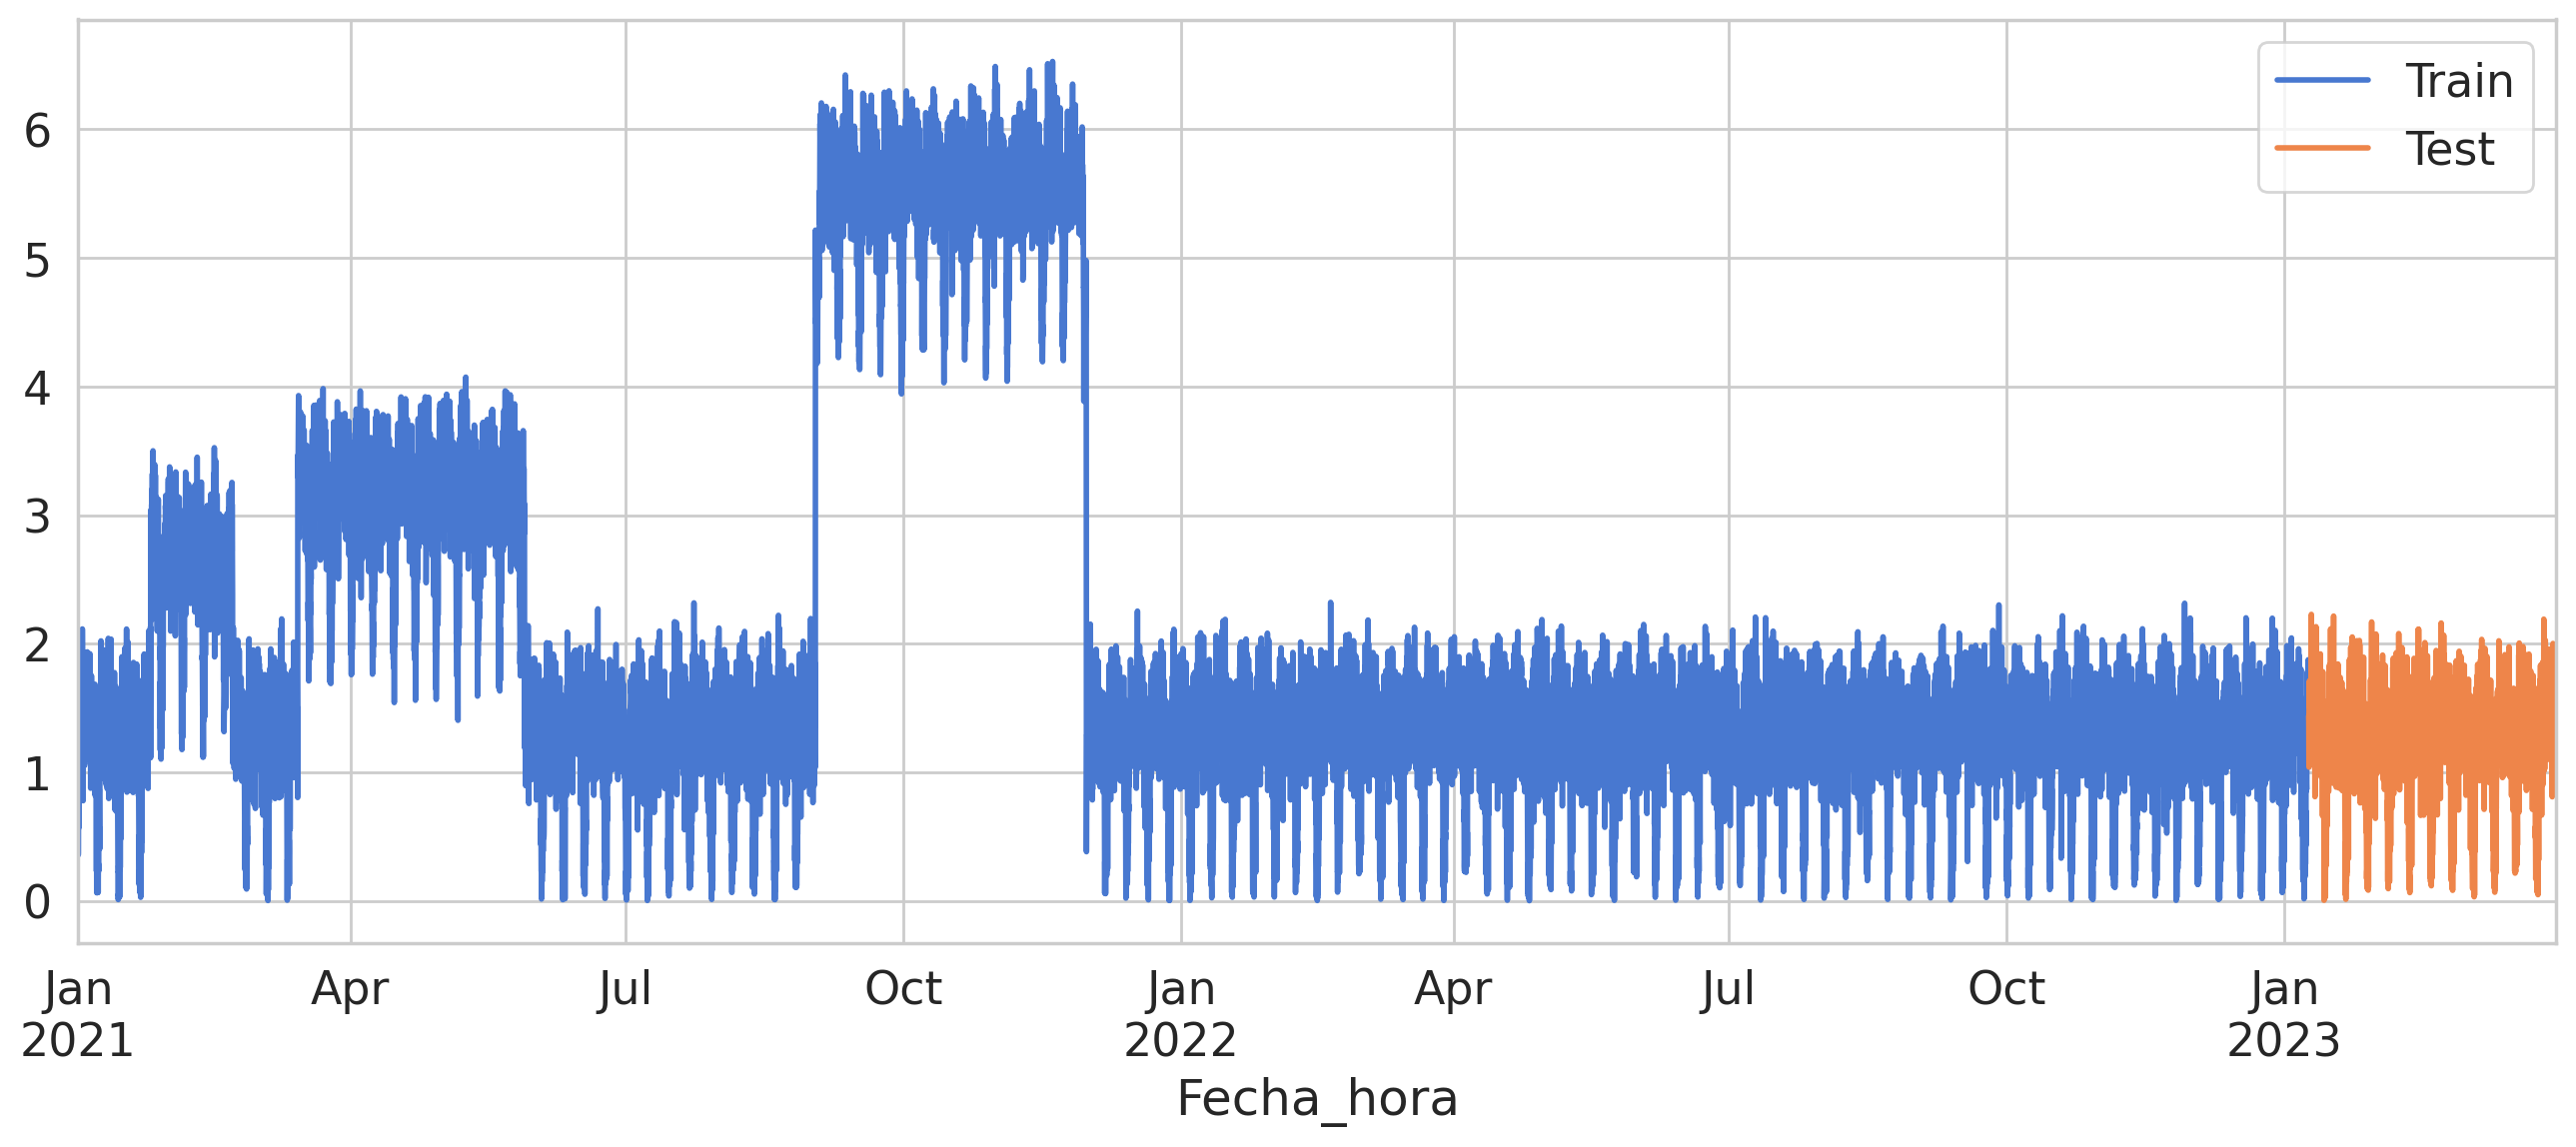

In [56]:
tr_df, te_df, df = get_train_test_generic(df_cliente1)
from pylab import rcParams
rcParams['figure.figsize'] = 16,6
tr_df['Energia_activa'].plot(label='Train', legend=True, linewidth=2)
te_df['Energia_activa'].plot(label='Test', legend=True, linewidth=2)
plt.show()

In [ ]:
 df.plot.hist(figsize=(15,5), bins=200, title="Distribución de la energía activa")

In [ ]:
df.loc[df.index.year == 2021].plot(figsize=(15,8), title='Energía activa año 2021', rot= 90)

In [ ]:
df.loc[(df.index.year == 2021) & (df.index.month == 1)].plot(figsize=(15,8), title='Energía activa año 2021 y mes Enero', rot= 90)

In [ ]:
df.loc[df.index.year == 2022].plot(figsize=(15,8), title='Energía activa año 2022', rot= 90)

In [ ]:
df.loc[df.index.year == 2023].plot(figsize=(15,8), title='Energía activa año 2023', rot= 90)

In [ ]:
single_week_mask = (df.index.year == 2023) & (df.index.month == 1) & (df.index.isocalendar().week == 2)
df.loc[single_week_mask].plot(figsize=(15,8), title='Energía activa año 2023 y mes Enero', rot= 90)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tr_df[['Energia_activa']], period =48)
from pylab import rcParams
rcParams['figure.figsize'] = 12,8
fig = result.plot()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print(acf(df["Energia_activa"]))
rcParams['figure.figsize'] = 12,4
plot_acf(df["Energia_activa"], lags=60);
plot_pacf(df["Energia_activa"], lags=60);

In [ ]:
from prophet import Prophet
tr_df, te_df, df = get_train_test_generic(df_cliente1, for_prophet=True, freq=None)
m = Prophet(daily_seasonality = True, weekly_seasonality=True, yearly_seasonality=False)
m.fit(tr_df)
future= m.make_future_dataframe(periods=len(te_df), freq='h', include_history=False)
forecast= m.predict(future)
fig = m.plot(forecast, figsize=(14, 6))
display(forecast.head())
m.plot_components(forecast);

In [ ]:
forecast.index = forecast.ds
plot_and_validate(tr_df, te_df, forecast, 'y', 'yhat')

In [ ]:
te_df.loc['2023-01-09']['y'].plot(legend=True, label='test')
forecast.loc['2023-01-09']['yhat'].plot(legend=True, label='forecast')

15:43:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1] done processing


mse=0.247, rmse=0.497, mae=0.388, mape=0.989, smape=0.358


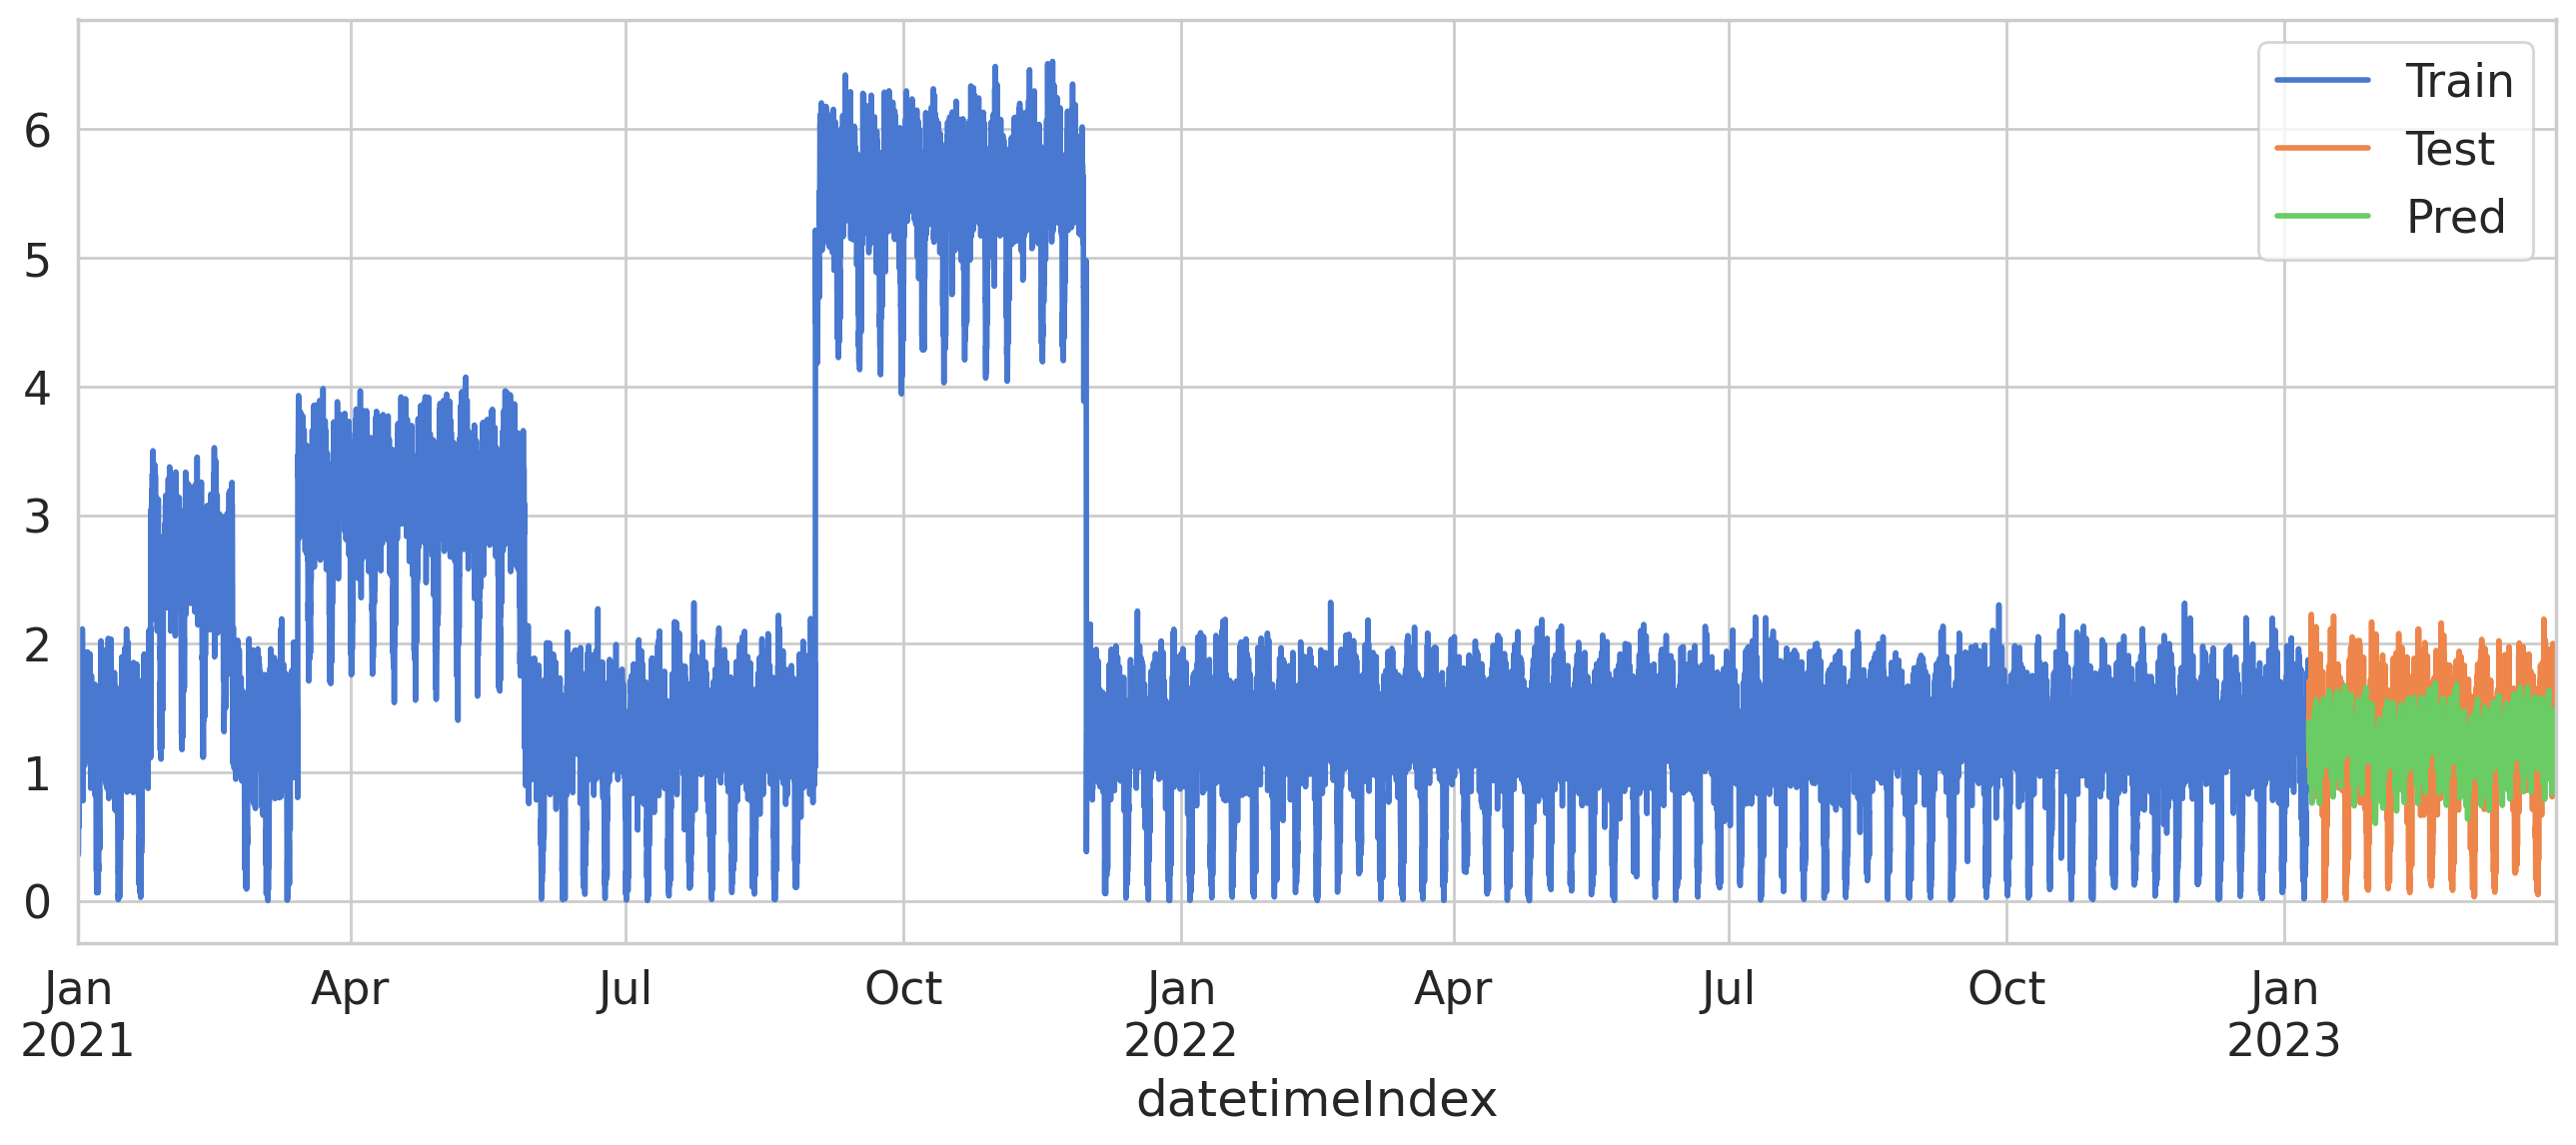

In [15]:
from prophet import Prophet
tr_df, te_df, df = get_train_test_generic(df_cliente1, for_prophet=True, freq=None)
m = Prophet(daily_seasonality = True, weekly_seasonality=True, yearly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.add_seasonality(name='dia_medio', period=2, fourier_order=10)
m.add_seasonality(name='dia', period=1, fourier_order=5)
m.fit(tr_df)
future= m.make_future_dataframe(periods=len(te_df), freq='h', include_history=False)
forecast= m.predict(future)
forecast.index = forecast.ds
plot_and_validate(tr_df, te_df, forecast, 'y', 'yhat')

In [ ]:
te_df.loc['2023-01-09']['y'].plot(legend=True, label='test')
forecast.loc['2023-01-09']['yhat'].plot(legend=True, label='forecast')

In [57]:
def is_high_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Wednesday','Friday','Sunday']

def is_low_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Thursday']

def is_low_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [2,14]

def is_high_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [7,8,9,10,11,12,19,20,21,22,23]

def generate_new_features(df):
    df['high_peak_week'] = df['ds'].apply(is_high_peak_week)
    df['low_peak_week'] = df['ds'].apply(is_low_peak_week)
    df['low_peak_hour'] = df['ds'].apply(is_low_peak_hour)
    df['high_peak_hour'] = df['ds'].apply(is_high_peak_hour)
    return df

In [18]:
tr_df, te_df, df = get_train_test_generic(df_cliente1, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

import time
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
start = time.time()
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'seasonality_mode': ['additive','multiplicative']
}

all_params = ParameterGrid(param_grid)
display(list(all_params))
mapes = []
rmses = []
for params in all_params:
    m = Prophet (yearly_seasonality = False,
                weekly_seasonality = params['weekly_seasonality'],
                daily_seasonality = params['daily_seasonality'],
                seasonality_mode = params['seasonality_mode'],
                changepoint_prior_scale = params['changepoint_prior_scale'],
                seasonality_prior_scale = params['seasonality_prior_scale']
                )
    m.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
    m.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
    m.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
    m.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
    m.fit(tr_df)
    cutoffs = pd.to_datetime(['2022-04-01','2022-08-01'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='20 days')
    df_p = performance_metrics(df_cv, rolling_window=5)
    print("mape = {}".format(df_p['mape'].iloc[0]))
    mapes.append(df_p['mape'].iloc[0])
    rmses.append(df_p['rmse'].iloc[0])
    print("Tiempo de ejecución = {}".format(params, time.time()- start))
    
#Encontrar los hiperparametros
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results['rmse'] = rmses
print(tuning_results)


#python
best_params = all_params[np.argmin(mapes)]
print(best_params)
print("Tiempo total = {}".format(time.time() - start))
display(tuning_results)
print(best_params)

[{'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False

15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:57:25 - cmdstanpy - INFO - Chain [1] start processing
15:57:27 - cmdstanpy - INFO - Chain [1] done processing
15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:34 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.282681937670442
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


15:57:38 - cmdstanpy - INFO - Chain [1] start processing
15:57:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:57:45 - cmdstanpy - INFO - Chain [1] start processing
15:57:47 - cmdstanpy - INFO - Chain [1] done processing
15:57:50 - cmdstanpy - INFO - Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3786843905111639
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:58:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:01 - cmdstanpy - INFO - Chain [1] start processing
15:58:05 - cmdstanpy - INFO - Chain [1] done processing
15:58:08 - cmdstanpy - INFO - Chain [1] start processing
15:58:13 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.2517030369042497
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


15:58:17 - cmdstanpy - INFO - Chain [1] start processing
15:58:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:23 - cmdstanpy - INFO - Chain [1] start processing
15:58:26 - cmdstanpy - INFO - Chain [1] done processing
15:58:29 - cmdstanpy - INFO - Chain [1] start processing
15:58:31 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.4046878589460825
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


15:58:35 - cmdstanpy - INFO - Chain [1] start processing
15:58:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:40 - cmdstanpy - INFO - Chain [1] start processing
15:58:43 - cmdstanpy - INFO - Chain [1] done processing
15:58:46 - cmdstanpy - INFO - Chain [1] start processing
15:58:49 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.287662356126177
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:59:02 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:07 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3307431376272885
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:59:18 - cmdstanpy - INFO - Chain [1] start processing
15:59:21 - cmdstanpy - INFO - Chain [1] done processing
15:59:24 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9929142857324506
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


15:59:31 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:59:37 - cmdstanpy - INFO - Chain [1] start processing
15:59:39 - cmdstanpy - INFO - Chain [1] done processing
15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:46 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3306341195464069
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


15:59:49 - cmdstanpy - INFO - Chain [1] start processing
15:59:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:59:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:56 - cmdstanpy - INFO - Chain [1] done processing
15:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:00:01 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.2414910637627066
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:00:05 - cmdstanpy - INFO - Chain [1] start processing
16:00:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:00:09 - cmdstanpy - INFO - Chain [1] start processing
16:00:11 - cmdstanpy - INFO - Chain [1] done processing
16:00:14 - cmdstanpy - INFO - Chain [1] start processing
16:00:16 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.428540327995151
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:00:20 - cmdstanpy - INFO - Chain [1] start processing
16:00:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:00:24 - cmdstanpy - INFO - Chain [1] start processing
16:00:26 - cmdstanpy - INFO - Chain [1] done processing
16:00:29 - cmdstanpy - INFO - Chain [1] start processing
16:00:32 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.2841399068453248
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:00:35 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:00:43 - cmdstanpy - INFO - Chain [1] start processing
16:00:45 - cmdstanpy - INFO - Chain [1] done processing
16:00:48 - cmdstanpy - INFO - Chain [1] start processing
16:00:53 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3752893505901862
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:00:56 - cmdstanpy - INFO - Chain [1] start processing
16:00:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:01:01 - cmdstanpy - INFO - Chain [1] start processing
16:01:02 - cmdstanpy - INFO - Chain [1] done processing
16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:07 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3611251543370528
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:01:10 - cmdstanpy - INFO - Chain [1] start processing
16:01:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:01:14 - cmdstanpy - INFO - Chain [1] start processing
16:01:18 - cmdstanpy - INFO - Chain [1] done processing
16:01:21 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3174505056554482
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:01:27 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:01:33 - cmdstanpy - INFO - Chain [1] start processing
16:01:36 - cmdstanpy - INFO - Chain [1] done processing
16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:43 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.159435992580822
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:01:46 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:01:52 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
16:01:57 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.3607784362848205
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:02:02 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:02:22 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
16:02:41 - cmdstanpy - INFO - Chain [1] start processing
16:02:54 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.952445023511504
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:02:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:51 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1211298487912233
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:03:54 - cmdstanpy - INFO - Chain [1] start processing
16:04:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:04:24 - cmdstanpy - INFO - Chain [1] start processing
16:04:34 - cmdstanpy - INFO - Chain [1] done processing
16:04:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:05 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9525176658342962
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:05:08 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:05:33 - cmdstanpy - INFO - Chain [1] start processing
16:05:48 - cmdstanpy - INFO - Chain [1] done processing
16:05:51 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1435661697972002
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:06:06 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
16:06:49 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.0760465527175158
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:07:00 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:07:19 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:42 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.0743203608339396
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:10:50 - cmdstanpy - INFO - Chain [1] done processing
16:10:54 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.113222473728153
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:11:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:10 - cmdstanpy - INFO - Chain [1] done processing
16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1604768903463372
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:14:00 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:29 - cmdstanpy - INFO - Chain [1] done processing
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9467210034732465
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.113476914206585
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9531291081484665
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:31 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1446588416802705
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:17:46 - cmdstanpy - INFO - Chain [1] start processing
16:18:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:17 - cmdstanpy - INFO - Chain [1] done processing
16:18:20 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.0698361669864203
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:18 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.083688540098895
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.114968650563856
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.0732348699329652
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9969353588237336
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:27:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:27:31 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:48 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1751515818759681
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:30:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:30:07 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:41 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9893522256712
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:32:41 - cmdstanpy - INFO - Chain [1] start processing
16:33:18 - cmdstanpy - INFO - Chain [1] done processing
16:33:21 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1767016852506034
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing
16:35:34 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1065841297302732
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:37:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:45 - cmdstanpy - INFO - Chain [1] done processing
16:37:48 - cmdstanpy - INFO - Chain [1] start processing
16:38:29 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1367582973246533
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:38:33 - cmdstanpy - INFO - Chain [1] start processing
16:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:42 - cmdstanpy - INFO - Chain [1] done processing
16:40:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.0892972727409636
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:41:53 - cmdstanpy - INFO - Chain [1] start processing
16:42:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:42:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:09 - cmdstanpy - INFO - Chain [1] done processing
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
16:43:45 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1252433033537623
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:43:49 - cmdstanpy - INFO - Chain [1] start processing
16:44:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:44:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:29 - cmdstanpy - INFO - Chain [1] done processing
16:45:32 - cmdstanpy - INFO - Chain [1] start processing
16:46:13 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9928951822683121
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:46:17 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:31 - cmdstanpy - INFO - Chain [1] done processing
16:47:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:11 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1709424346171369
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:48:15 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:49:21 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:50:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 0.9900545648345727
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:51:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:05 - cmdstanpy - INFO - Chain [1] done processing
16:52:08 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1765011550345779
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


16:53:06 - cmdstanpy - INFO - Chain [1] start processing
16:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:53:57 - cmdstanpy - INFO - Chain [1] start processing
16:54:23 - cmdstanpy - INFO - Chain [1] done processing
16:54:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:02 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1053025989582246
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:55:53 - cmdstanpy - INFO - Chain [1] start processing
16:56:11 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1366664110547284
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


16:56:55 - cmdstanpy - INFO - Chain [1] start processing
16:57:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:57:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:17 - cmdstanpy - INFO - Chain [1] done processing
16:58:20 - cmdstanpy - INFO - Chain [1] start processing
16:59:09 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.086219924659087
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


16:59:12 - cmdstanpy - INFO - Chain [1] start processing
16:59:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

16:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:00:19 - cmdstanpy - INFO - Chain [1] done processing
17:00:22 - cmdstanpy - INFO - Chain [1] start processing
17:00:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.1392098503169434
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}
    changepoint_prior_scale  daily_seasonality seasonality_mode  \
0                     0.001               True         additive   
1                     0.001               True         additive   
2                     0.001               True         additive   
3                     0.001               True         additive   
4                     0.001               True   multiplicative   
5                     0.001               True   multiplicative   
6                     0.001               True   multiplicative   
7                     0.001               True   multiplicative   
8                     0.001              False         additive   
9                     0.001              False         additive   
10                    0.001              False         

/tmp/ipykernel_33/2570970365.py:50: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  best_params = all_params[np.argmin(mapes)]


,changepoint_prior_scale,daily_seasonality,seasonality_mode,seasonality_prior_scale,weekly_seasonality,mape,rmse
0,0.001,True,additive,0.01,True,1.282682,0.684439
1,0.001,True,additive,0.01,False,1.378684,0.682667
2,0.001,True,additive,1.00,True,1.251703,0.682637
3,0.001,True,additive,1.00,False,1.404688,0.683681
4,0.001,True,multiplicative,0.01,True,1.287662,0.626769
5,0.001,True,multiplicative,0.01,False,1.330743,0.646109
6,0.001,True,multiplicative,1.00,True,0.992914,0.561568
7,0.001,True,multiplicative,1.00,False,1.330634,0.695335
8,0.001,False,additive,0.01,True,1.241491,0.657831
9,0.001,False,additive,0.01,False,1.428540,0.704730


{'weekly_seasonality': True, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'daily_seasonality': False, 'changepoint_prior_scale': 0.01}


In [ ]:
mape = 0.7736562037988735
rmse = 0.504752
parms_1 = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 
                       'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}

mape = 0.820145
rmse = 0.416632
params_2 = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 
                       'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


{'weekly_seasonality': True, 'seasonality_prior_scale': 0.01, 
 'seasonality_mode': 'additive', 'daily_seasonality': False, 'changepoint_prior_scale': 0.01}

22:15:33 - cmdstanpy - INFO - Chain [1] start processing
22:15:54 - cmdstanpy - INFO - Chain [1] done processing


mse=0.241, rmse=0.491, mae=0.384, mape=0.957, smape=0.356


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,high_peak_hour,high_peak_hour_lower,high_peak_hour_upper,high_peak_week,high_peak_week_lower,high_peak_week_upper,low_peak_hour,low_peak_hour_lower,low_peak_hour_upper,low_peak_week,low_peak_week_lower,low_peak_week_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,2023-01-09 00:00:00,1.254481,0.611666,2.368546,1.254481,1.254481,0.211177,0.211177,0.211177,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.211177,0.211177,0.211177,0.0,0.0,0.0,1.465658
2023-01-09 01:00:00,2023-01-09 01:00:00,1.254481,0.563684,2.379705,1.254481,1.254481,0.192304,0.192304,0.192304,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.192304,0.192304,0.192304,0.0,0.0,0.0,1.446785
2023-01-09 02:00:00,2023-01-09 02:00:00,1.254482,0.232577,2.060158,1.254482,1.254482,-0.111300,-0.111300,-0.111300,0.0,0.0,0.0,0.0,0.0,0.0,-0.282903,-0.282903,-0.282903,0.0,0.0,0.0,0.171603,0.171603,0.171603,0.0,0.0,0.0,1.143182
2023-01-09 03:00:00,2023-01-09 03:00:00,1.254483,0.567429,2.301267,1.254483,1.254483,0.149240,0.149240,0.149240,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.149240,0.149240,0.149240,0.0,0.0,0.0,1.403723
2023-01-09 04:00:00,2023-01-09 04:00:00,1.254483,0.513645,2.333208,1.254483,1.254483,0.125398,0.125398,0.125398,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.125398,0.125398,0.125398,0.0,0.0,0.0,1.379882


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

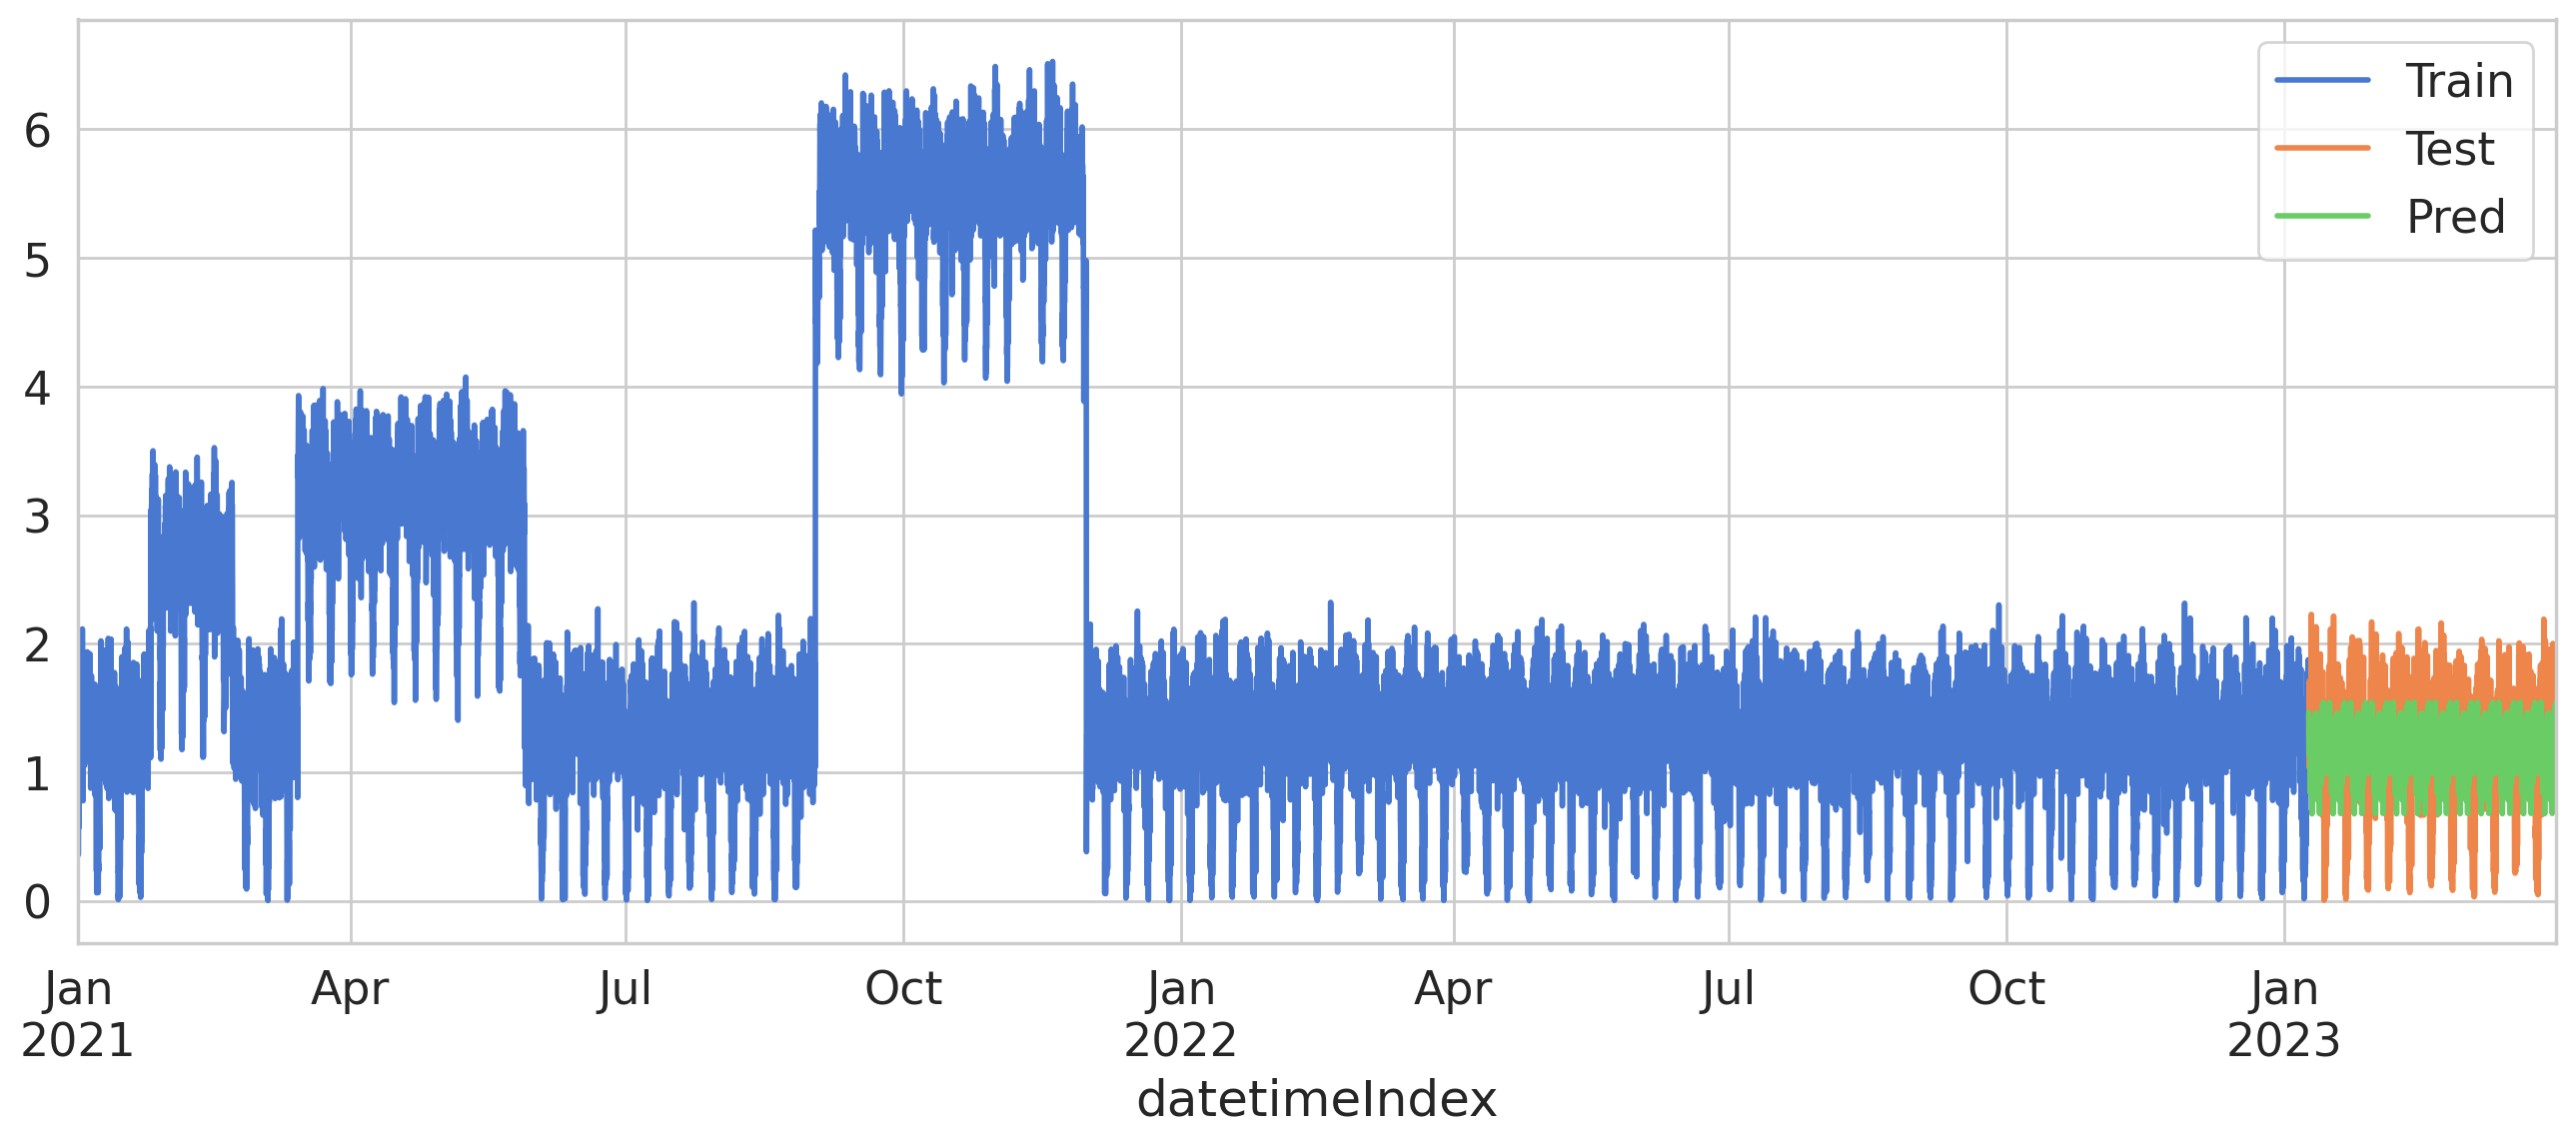

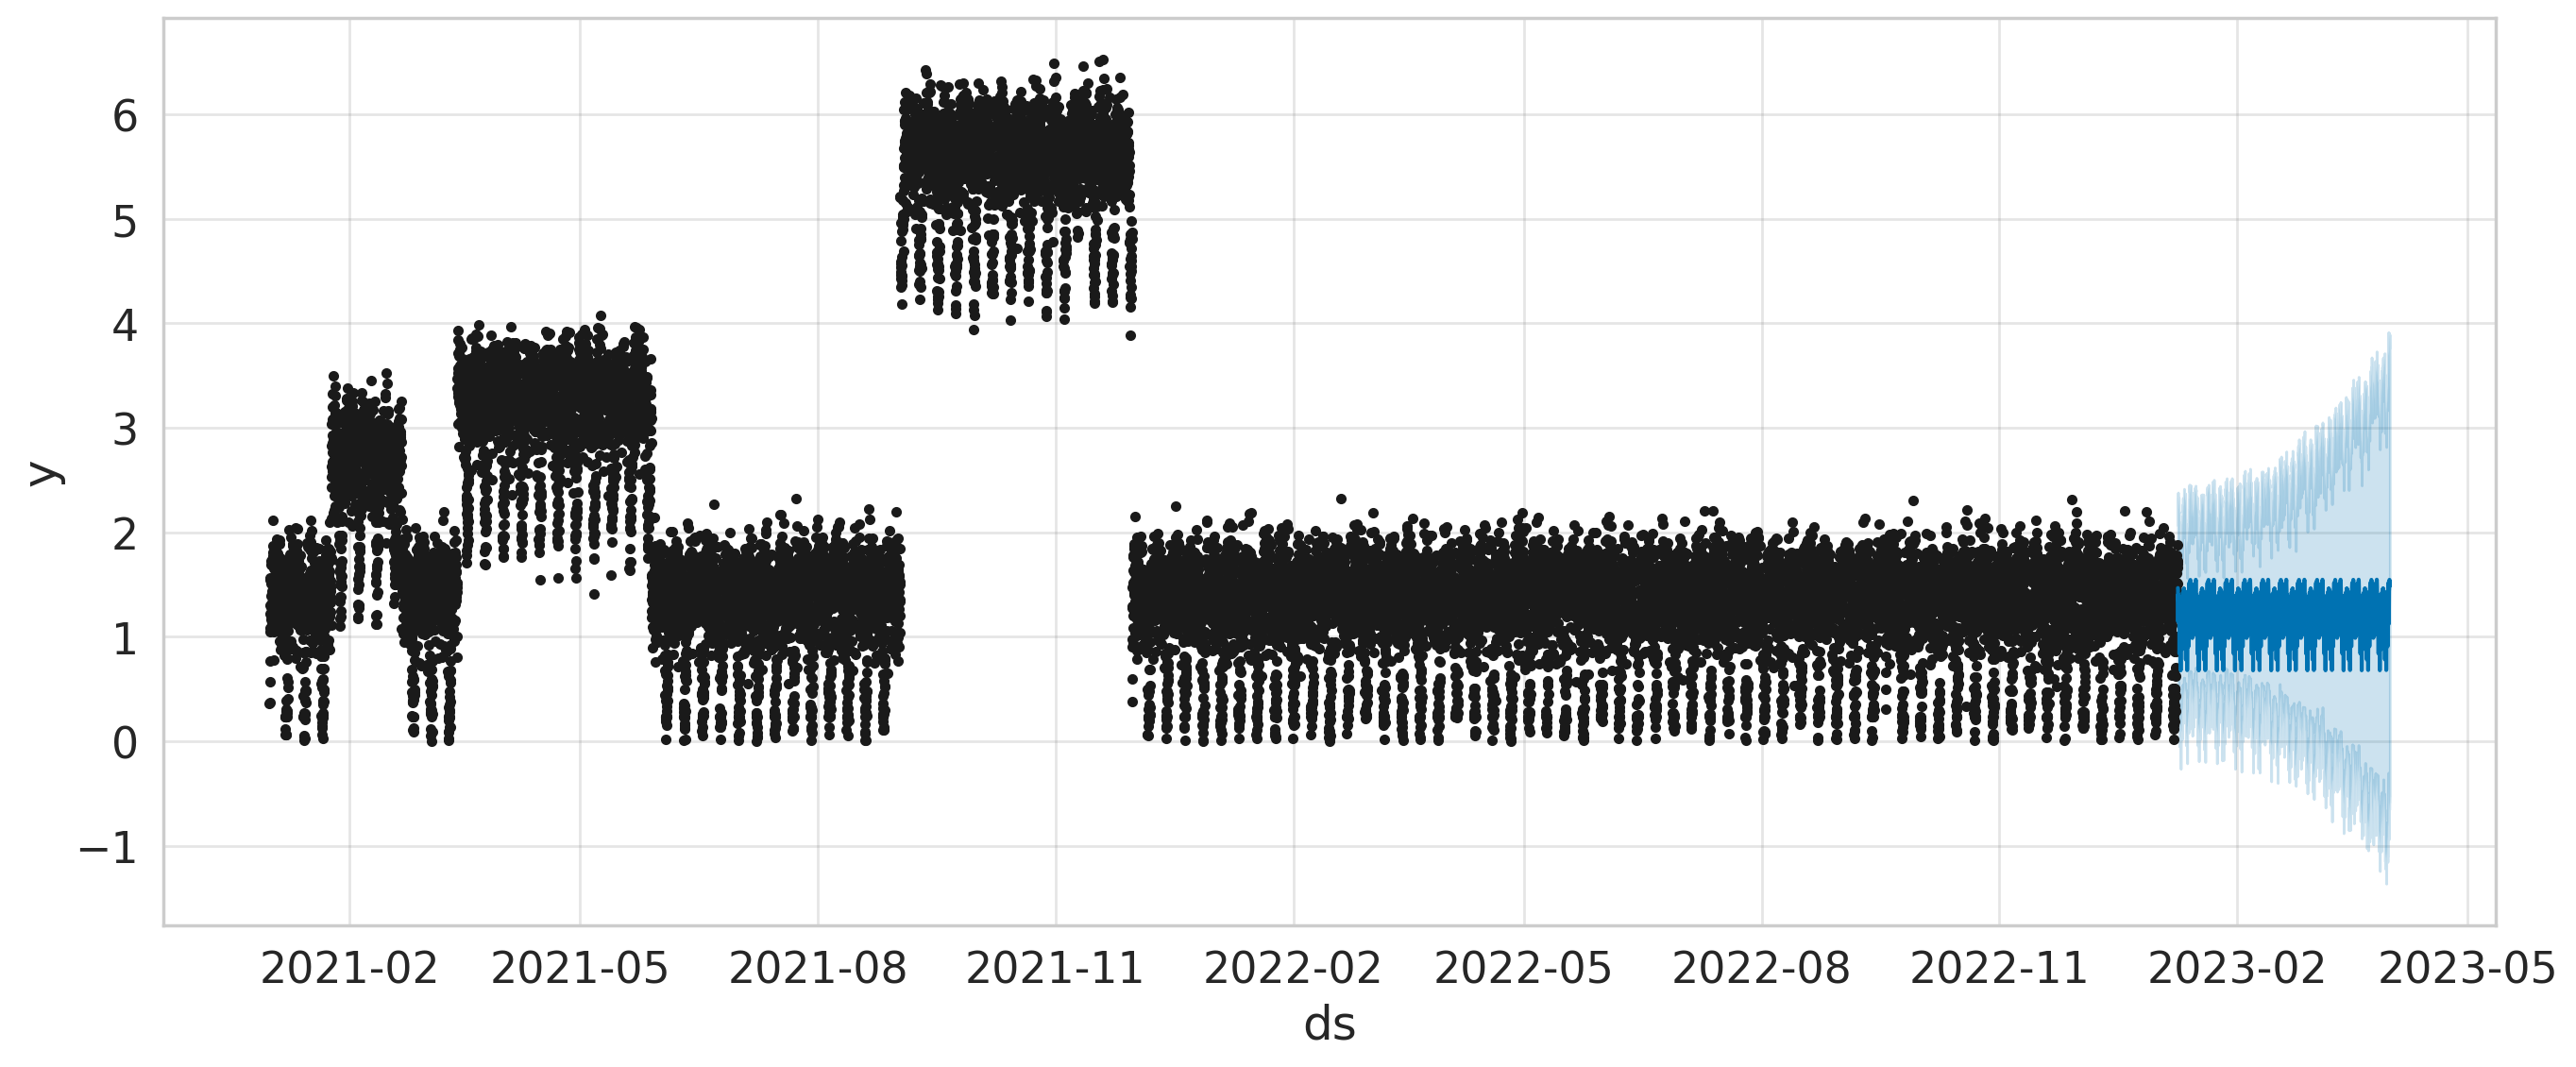

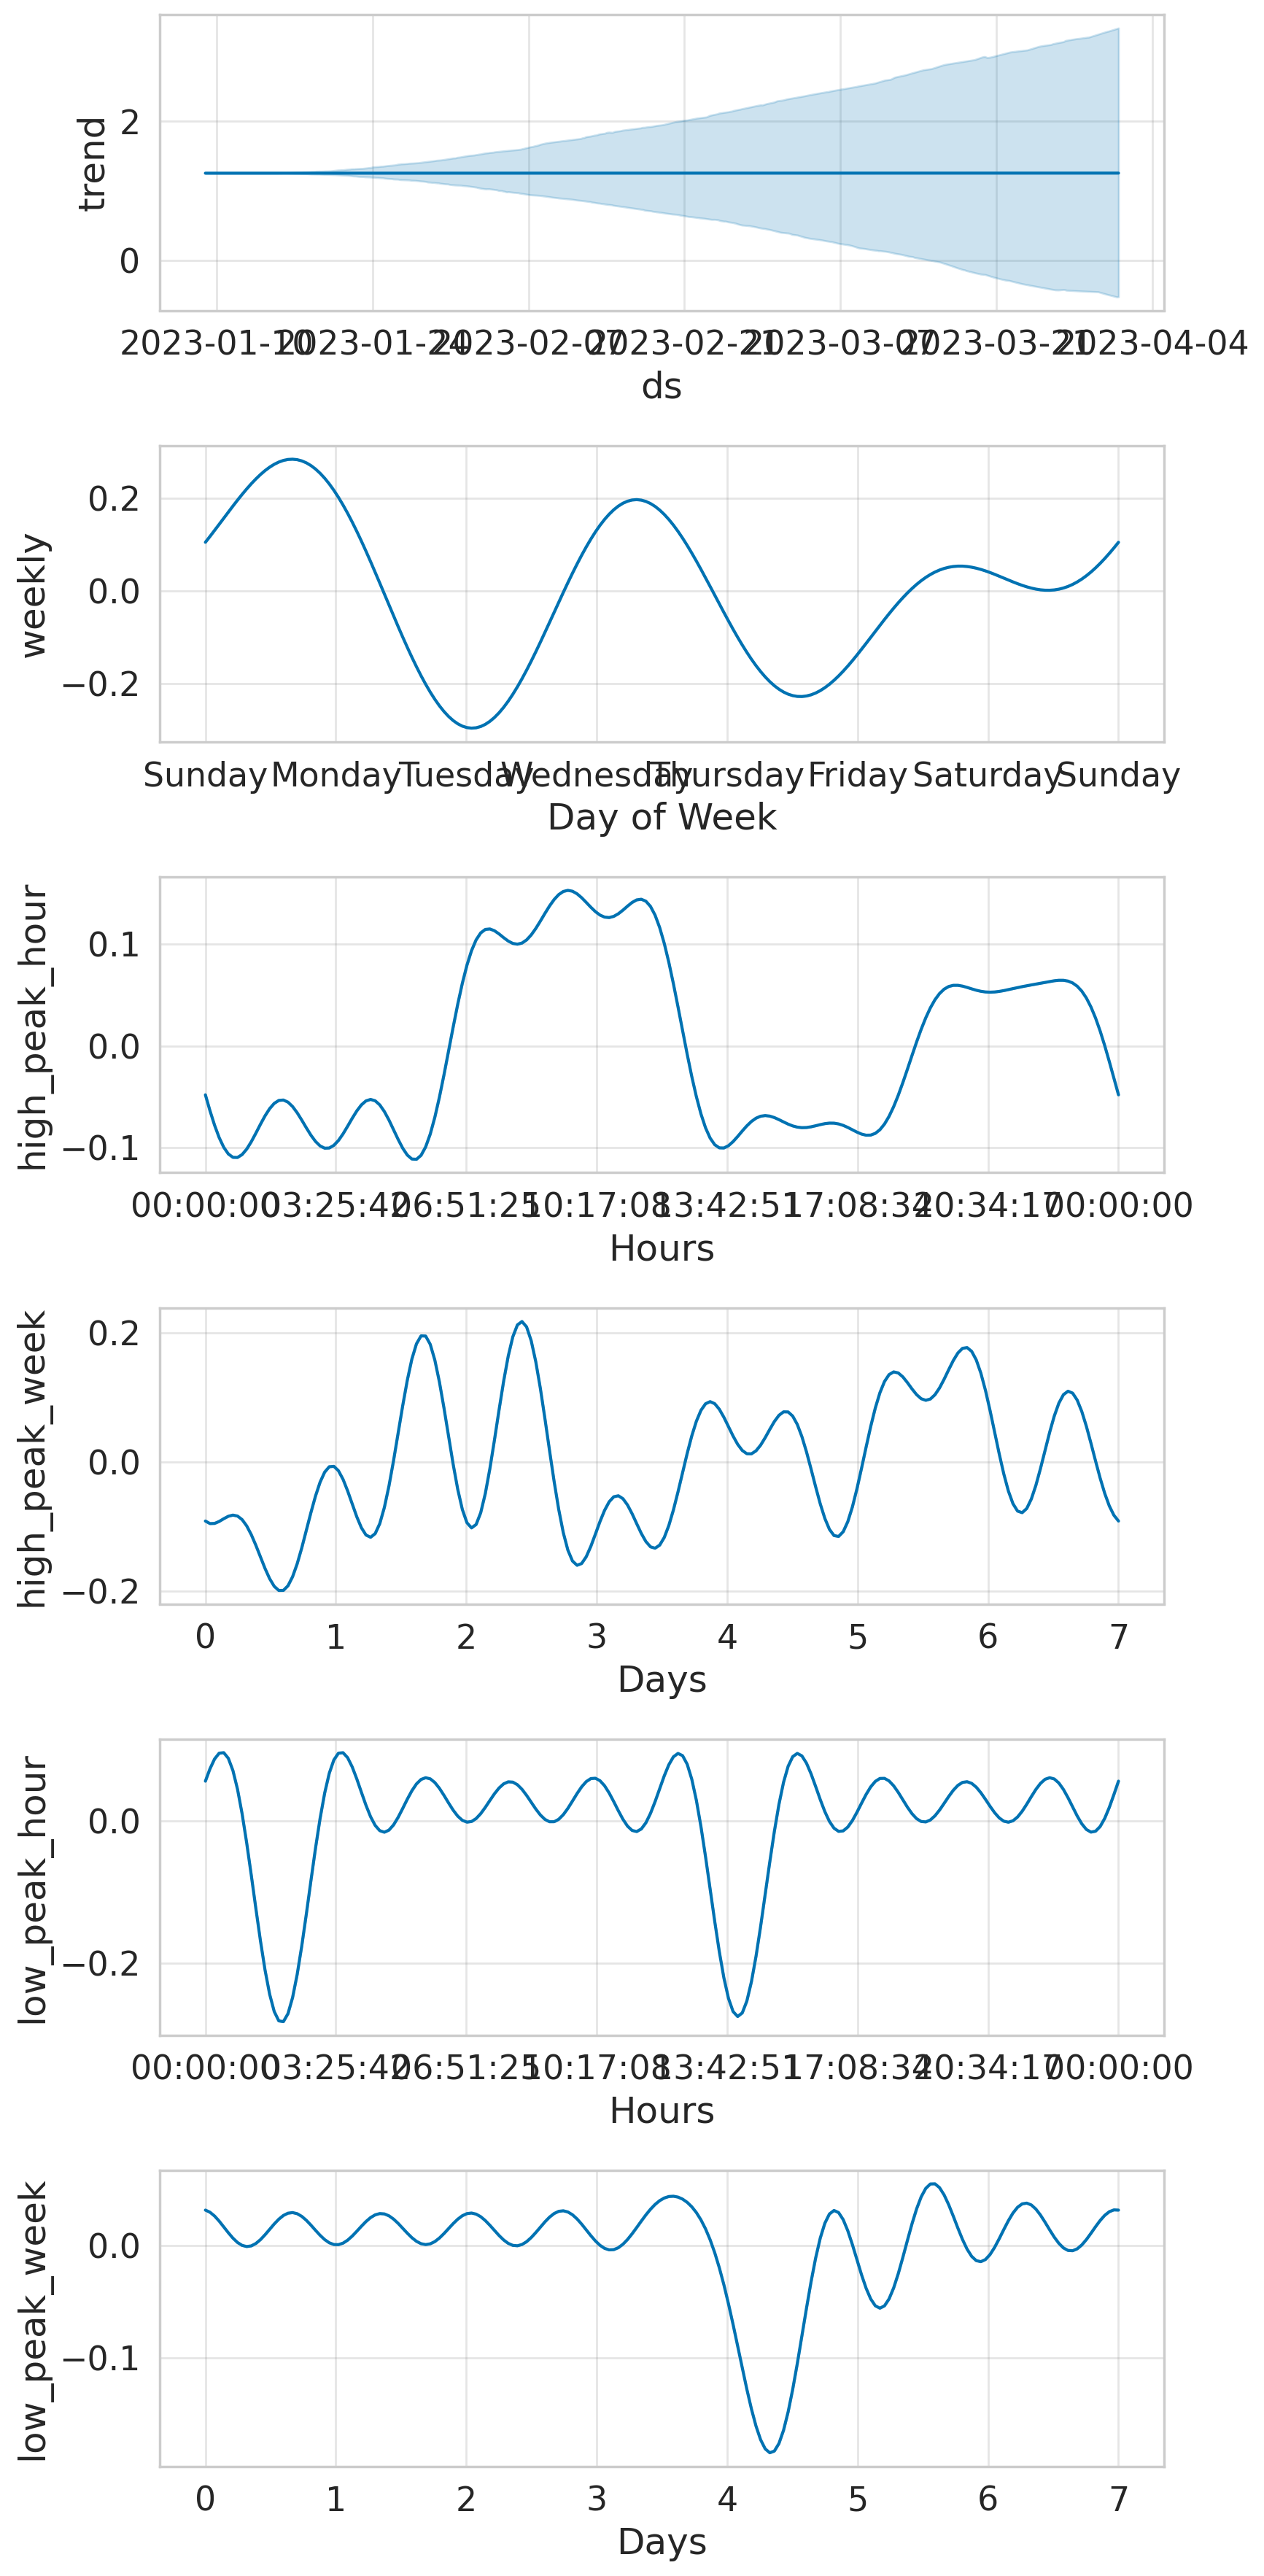

In [59]:
tr_df, te_df, df = get_train_test_generic(df_cliente1, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

m1 = Prophet(daily_seasonality = False, weekly_seasonality=True, yearly_seasonality=False, 
            changepoint_prior_scale = 0.01, seasonality_mode='additive', seasonality_prior_scale = 0.01)
m1.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
m1.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
m1.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
m1.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
m1.fit(tr_df)
future1= m1.make_future_dataframe(periods=len(te_df), freq='h', include_history=False)
future1= generate_new_features(future1)
forecast1= m1.predict(future1)
forecast1.index = forecast1.ds
plot_and_validate(tr_df, te_df, forecast1, 'y', 'yhat')
fig = m1.plot(forecast1, figsize=(14, 6))
display(forecast1.head())
m1.plot_components(forecast1);

### Cliente 6

In [60]:
def is_high_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Monday','Tuesday','Friday','Saturday']

def is_low_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Wednesday']

def is_low_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [21, 22, 23]

def is_high_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [8,9]

def generate_new_features(df):
    df['high_peak_week'] = df['ds'].apply(is_high_peak_week)
    df['low_peak_week'] = df['ds'].apply(is_low_peak_week)
    df['low_peak_hour'] = df['ds'].apply(is_low_peak_hour)
    df['high_peak_hour'] = df['ds'].apply(is_high_peak_hour)
    return df

In [17]:
tr_df, te_df, df = get_train_test_generic(df_cliente6, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

import time
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
start = time.time()
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'seasonality_mode': ['additive','multiplicative']
}

all_params = ParameterGrid(param_grid)
display(list(all_params))
mapes = []
rmses = []
for params in all_params:
    m = Prophet (yearly_seasonality = False,
                weekly_seasonality = params['weekly_seasonality'],
                daily_seasonality = params['daily_seasonality'],
                seasonality_mode = params['seasonality_mode'],
                changepoint_prior_scale = params['changepoint_prior_scale'],
                seasonality_prior_scale = params['seasonality_prior_scale']
                )
    m.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
    m.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
    m.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
    m.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
    m.fit(tr_df)
    cutoffs = pd.to_datetime(['2022-04-01','2022-08-01'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='10 days')
    df_p = performance_metrics(df_cv, rolling_window=5)
    print("mape = {}".format(df_p['mape'].iloc[0]))
    mapes.append(df_p['mape'].iloc[0])
    rmses.append(df_p['rmse'].iloc[0])
    print("Tiempo de ejecución = {}".format(params, time.time()- start))
    
#Encontrar los hiperparametros
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results['rmse'] = rmses
print(tuning_results)


#python
best_params = all_params[np.argmin(mapes)]
print(best_params)
print("Tiempo total = {}".format(time.time() - start))
display(tuning_results)
print(best_params)

[{'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False

20:09:42 - cmdstanpy - INFO - Chain [1] start processing
20:09:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:48 - cmdstanpy - INFO - Chain [1] done processing
20:09:51 - cmdstanpy - INFO - Chain [1] start processing
20:09:55 - cmdstanpy - INFO - Chain [1] done processing


mape = 4.007765220077022
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:09:58 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:10:03 - cmdstanpy - INFO - Chain [1] start processing
20:10:06 - cmdstanpy - INFO - Chain [1] done processing
20:10:09 - cmdstanpy - INFO - Chain [1] start processing
20:10:11 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.967906210487119
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:10:24 - cmdstanpy - INFO - Chain [1] start processing
20:10:26 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:33 - cmdstanpy - INFO - Chain [1] done processing


mape = 4.012991511671809
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:10:37 - cmdstanpy - INFO - Chain [1] start processing
20:10:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:10:42 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing
20:10:47 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing


mape = 4.023267816814285
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:10:54 - cmdstanpy - INFO - Chain [1] start processing
20:10:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:11:00 - cmdstanpy - INFO - Chain [1] start processing
20:11:03 - cmdstanpy - INFO - Chain [1] done processing
20:11:06 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.739988932063776
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:11:12 - cmdstanpy - INFO - Chain [1] start processing
20:11:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:11:18 - cmdstanpy - INFO - Chain [1] start processing
20:11:20 - cmdstanpy - INFO - Chain [1] done processing
20:11:23 - cmdstanpy - INFO - Chain [1] start processing
20:11:25 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.6821467034334385
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:11:29 - cmdstanpy - INFO - Chain [1] start processing
20:11:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:11:43 - cmdstanpy - INFO - Chain [1] start processing
20:11:48 - cmdstanpy - INFO - Chain [1] done processing
20:11:51 - cmdstanpy - INFO - Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.833133785786716
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:12:02 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:12:07 - cmdstanpy - INFO - Chain [1] start processing
20:12:11 - cmdstanpy - INFO - Chain [1] done processing
20:12:14 - cmdstanpy - INFO - Chain [1] start processing
20:12:17 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.6418602076503768
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:12:21 - cmdstanpy - INFO - Chain [1] start processing
20:12:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:12:28 - cmdstanpy - INFO - Chain [1] start processing
20:12:31 - cmdstanpy - INFO - Chain [1] done processing
20:12:34 - cmdstanpy - INFO - Chain [1] start processing
20:12:37 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.9703806816979155
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:12:40 - cmdstanpy - INFO - Chain [1] start processing
20:12:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:12:44 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:49 - cmdstanpy - INFO - Chain [1] start processing
20:12:52 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.949206236497545
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:12:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:13:02 - cmdstanpy - INFO - Chain [1] start processing
20:13:04 - cmdstanpy - INFO - Chain [1] done processing
20:13:07 - cmdstanpy - INFO - Chain [1] start processing
20:13:09 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.998628900557405
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:13:17 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:22 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.9947803206206394
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:13:29 - cmdstanpy - INFO - Chain [1] start processing
20:13:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:39 - cmdstanpy - INFO - Chain [1] done processing
20:13:42 - cmdstanpy - INFO - Chain [1] start processing
20:13:44 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.751720217405517
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:13:48 - cmdstanpy - INFO - Chain [1] start processing
20:13:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:53 - cmdstanpy - INFO - Chain [1] done processing
20:13:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:59 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.6950371708636505
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:14:02 - cmdstanpy - INFO - Chain [1] start processing
20:14:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:14:15 - cmdstanpy - INFO - Chain [1] start processing
20:14:19 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:27 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.8892312185882267
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:14:30 - cmdstanpy - INFO - Chain [1] start processing
20:14:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:14:36 - cmdstanpy - INFO - Chain [1] start processing
20:14:38 - cmdstanpy - INFO - Chain [1] done processing
20:14:41 - cmdstanpy - INFO - Chain [1] start processing
20:14:43 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.697188242688997
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:15:00 - cmdstanpy - INFO - Chain [1] done processing
20:15:03 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.8982997207781063
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:27 - cmdstanpy - INFO - Chain [1] start processing
20:15:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.8776523851178615
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:15:39 - cmdstanpy - INFO - Chain [1] start processing
20:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:15:52 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:16:04 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.948554709132428
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:16:08 - cmdstanpy - INFO - Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:16:25 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:30 - cmdstanpy - INFO - Chain [1] start processing
20:16:42 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.93249720391787
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:16:46 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:17:05 - cmdstanpy - INFO - Chain [1] start processing
20:17:09 - cmdstanpy - INFO - Chain [1] done processing
20:17:12 - cmdstanpy - INFO - Chain [1] start processing
20:17:21 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.600308166698236
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:17:25 - cmdstanpy - INFO - Chain [1] start processing
20:17:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:17:40 - cmdstanpy - INFO - Chain [1] start processing
20:17:42 - cmdstanpy - INFO - Chain [1] done processing
20:17:45 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.618111347555712
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:18:00 - cmdstanpy - INFO - Chain [1] start processing
20:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:54 - cmdstanpy - INFO - Chain [1] done processing
20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:08 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.7975174534196838
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:19:11 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:19:24 - cmdstanpy - INFO - Chain [1] start processing
20:19:28 - cmdstanpy - INFO - Chain [1] done processing
20:19:31 - cmdstanpy - INFO - Chain [1] start processing
20:19:43 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.4922956679493287
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:19:47 - cmdstanpy - INFO - Chain [1] start processing
20:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:19:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:04 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing
20:20:13 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.8646453816618362
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:20:26 - cmdstanpy - INFO - Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing
20:20:31 - cmdstanpy - INFO - Chain [1] start processing
20:20:34 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.8288813349799633
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:20:48 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.8967071739366608
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:21:05 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:31 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.870219529396288
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:21:54 - cmdstanpy - INFO - Chain [1] start processing
20:21:57 - cmdstanpy - INFO - Chain [1] done processing
20:22:00 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.6746779746952787
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:22:09 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.670076211507095
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:22:42 - cmdstanpy - INFO - Chain [1] start processing
20:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:23:00 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:11 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.9349692033422685
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:23:27 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:40 - cmdstanpy - INFO - Chain [1] done processing
20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.5949460694076323
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:24:36 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:53 - cmdstanpy - INFO - Chain [1] start processing
20:25:21 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.315439386650813
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:25:25 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:26:09 - cmdstanpy - INFO - Chain [1] start processing
20:26:20 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.2890558466339295
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:26:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:51 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:28:30 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.3679714514657806
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:28:34 - cmdstanpy - INFO - Chain [1] start processing
20:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:29:22 - cmdstanpy - INFO - Chain [1] start processing
20:29:40 - cmdstanpy - INFO - Chain [1] done processing
20:29:43 - cmdstanpy - INFO - Chain [1] start processing
20:30:19 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.3522553888444624
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:30:22 - cmdstanpy - INFO - Chain [1] start processing
20:30:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:31:01 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing
20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.757187701989438
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:31:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:32:25 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:43 - cmdstanpy - INFO - Chain [1] start processing
20:33:15 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.7882054679734563
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:33:19 - cmdstanpy - INFO - Chain [1] start processing
20:34:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:34:29 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:24 - cmdstanpy - INFO - Chain [1] start processing
20:36:09 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.412290512699008
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:36:13 - cmdstanpy - INFO - Chain [1] start processing
20:37:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:37:13 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.6915000296396476
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:38:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:38:39 - cmdstanpy - INFO - Chain [1] start processing
20:38:51 - cmdstanpy - INFO - Chain [1] done processing
20:38:54 - cmdstanpy - INFO - Chain [1] start processing
20:39:19 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.2561404517945918
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:39:23 - cmdstanpy - INFO - Chain [1] start processing
20:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:40:10 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:39 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.1905828004228294
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:41:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:41:20 - cmdstanpy - INFO - Chain [1] start processing
20:41:36 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:42:05 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.339959105104242
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:42:08 - cmdstanpy - INFO - Chain [1] start processing
20:42:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:42:39 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:43:18 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.214238556424038
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:44:00 - cmdstanpy - INFO - Chain [1] start processing
20:44:18 - cmdstanpy - INFO - Chain [1] done processing
20:44:21 - cmdstanpy - INFO - Chain [1] start processing
20:44:44 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.8051852023733947
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:44:48 - cmdstanpy - INFO - Chain [1] start processing
20:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.8202240543164452
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:46:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:00 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.4382404081826883
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:49:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:42 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.7502950038357556
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}
    changepoint_prior_scale  daily_seasonality seasonality_mode  \
0                     0.001               True         additive   
1                     0.001               True         additive   
2                     0.001               True         additive   
3                     0.001               True         additive   
4                     0.001               True   multiplicative   
5                     0.001               True   multiplicative   
6                     0.001               True   multiplicative   
7                     0.001               True   multiplicative   
8                     0.001              False         additive   
9                     0.001              False         additive   
10                    0.001              False         

/tmp/ipykernel_34/1944749797.py:50: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  best_params = all_params[np.argmin(mapes)]


,changepoint_prior_scale,daily_seasonality,seasonality_mode,seasonality_prior_scale,weekly_seasonality,mape,rmse
0,0.001,True,additive,0.01,True,4.007765,1.768939
1,0.001,True,additive,0.01,False,3.967906,1.752630
2,0.001,True,additive,1.00,True,4.012992,1.777409
3,0.001,True,additive,1.00,False,4.023268,1.771955
4,0.001,True,multiplicative,0.01,True,3.739989,1.761221
5,0.001,True,multiplicative,0.01,False,3.682147,1.716865
6,0.001,True,multiplicative,1.00,True,3.833134,1.827419
7,0.001,True,multiplicative,1.00,False,3.641860,1.784796
8,0.001,False,additive,0.01,True,3.970381,1.744968
9,0.001,False,additive,0.01,False,3.949206,1.727107


{'weekly_seasonality': True, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'daily_seasonality': True, 'changepoint_prior_scale': 0.1}


22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:19:33 - cmdstanpy - INFO - Chain [1] done processing


mse=0.463, rmse=0.680, mae=0.416, mape=0.832, smape=0.740


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,high_peak_hour,high_peak_hour_lower,high_peak_hour_upper,high_peak_week,high_peak_week_lower,high_peak_week_upper,low_peak_hour,low_peak_hour_lower,low_peak_hour_upper,low_peak_week,low_peak_week_lower,low_peak_week_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,2023-01-09 00:00:00,0.407424,-0.829232,1.637636,0.407424,0.407424,0.0,0.0,0.0,-0.071839,-0.071839,-0.071839,0.0,0.0,0.0,0.0,0.0,0.0,-0.071839,-0.071839,-0.071839,0.0,0.0,0.0,0.378155
2023-01-09 01:00:00,2023-01-09 01:00:00,0.407415,-0.928970,1.649687,0.407415,0.407415,0.0,0.0,0.0,-0.085063,-0.085063,-0.085063,0.0,0.0,0.0,0.0,0.0,0.0,-0.085063,-0.085063,-0.085063,0.0,0.0,0.0,0.372759
2023-01-09 02:00:00,2023-01-09 02:00:00,0.407406,-0.910866,1.614552,0.407406,0.407406,0.0,0.0,0.0,-0.088881,-0.088881,-0.088881,0.0,0.0,0.0,0.0,0.0,0.0,-0.088881,-0.088881,-0.088881,0.0,0.0,0.0,0.371196
2023-01-09 03:00:00,2023-01-09 03:00:00,0.407397,-0.910638,1.502963,0.407397,0.407397,0.0,0.0,0.0,-0.081795,-0.081795,-0.081795,0.0,0.0,0.0,0.0,0.0,0.0,-0.081795,-0.081795,-0.081795,0.0,0.0,0.0,0.374074
2023-01-09 04:00:00,2023-01-09 04:00:00,0.407388,-0.866119,1.557833,0.407388,0.407388,0.0,0.0,0.0,-0.063044,-0.063044,-0.063044,0.0,0.0,0.0,0.0,0.0,0.0,-0.063044,-0.063044,-0.063044,0.0,0.0,0.0,0.381705


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

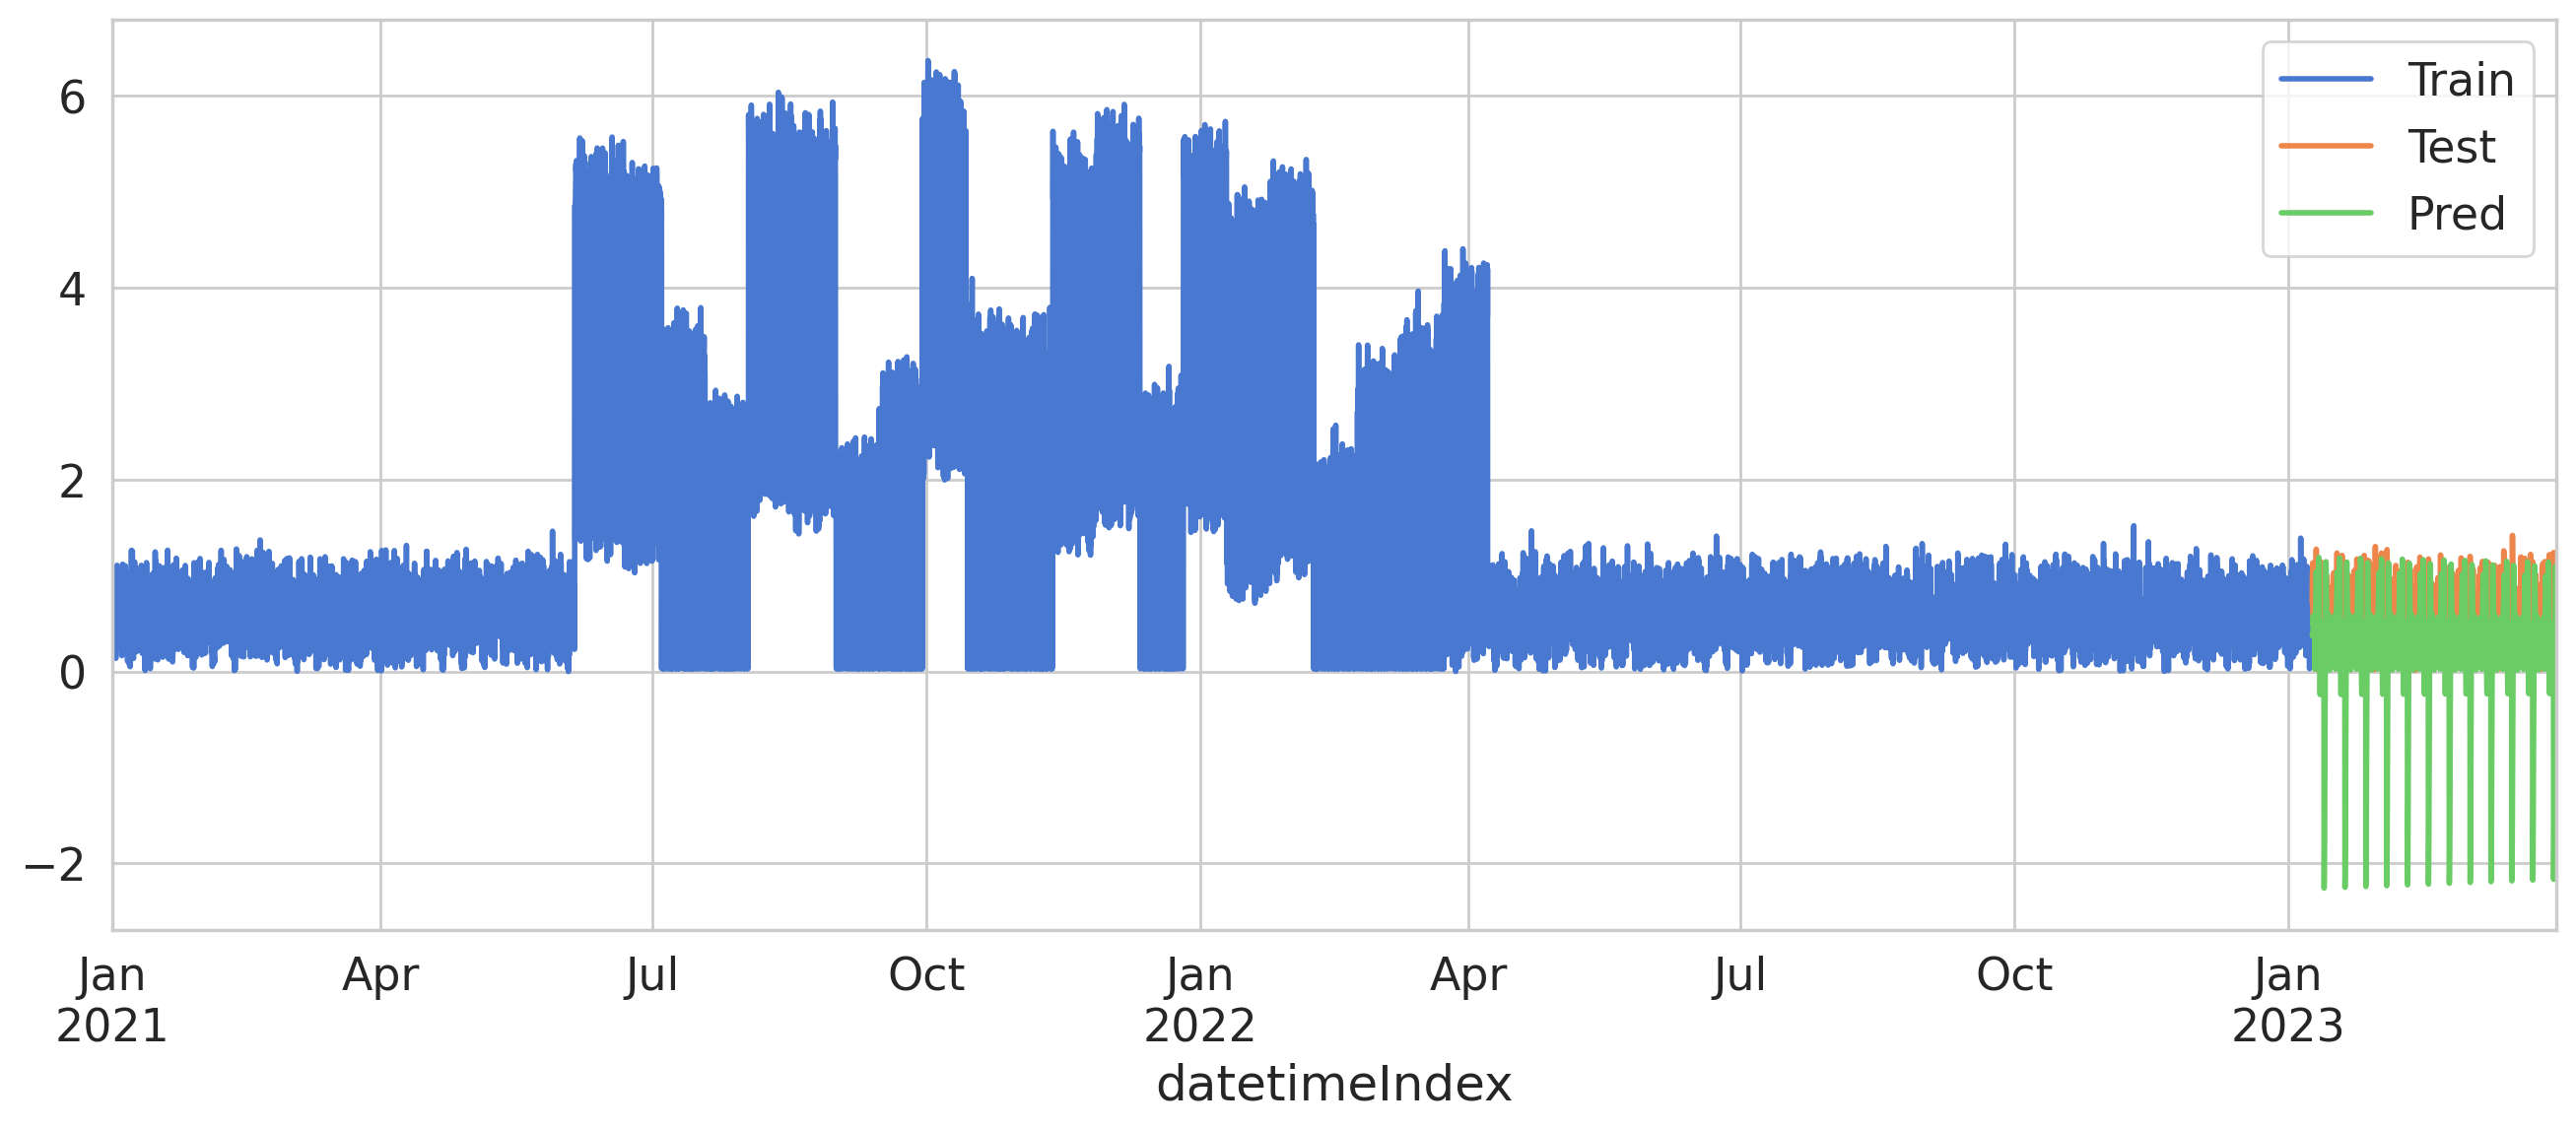

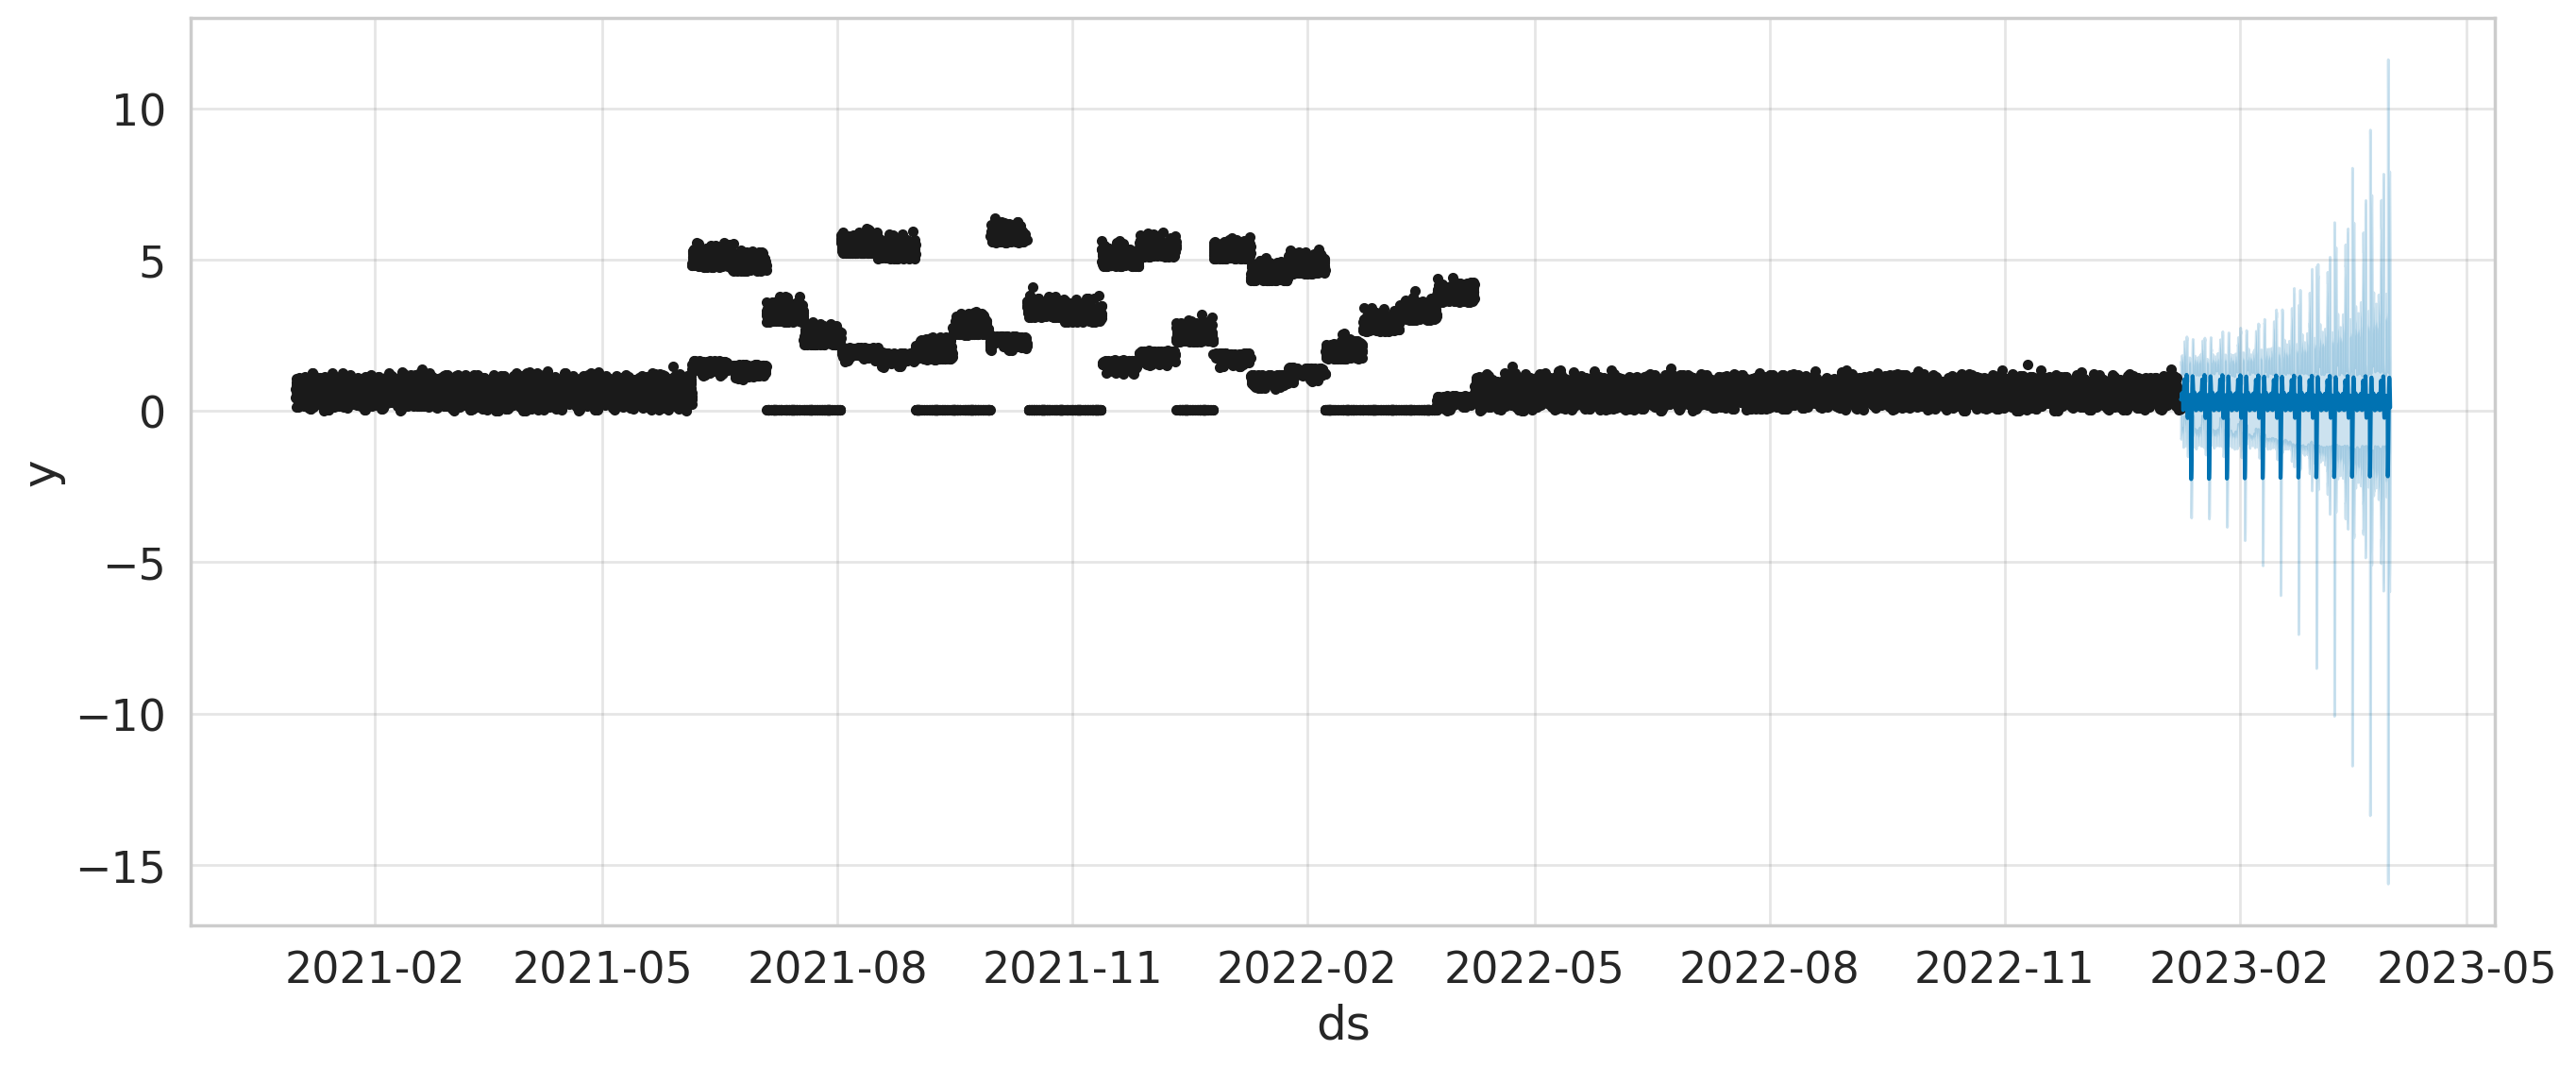

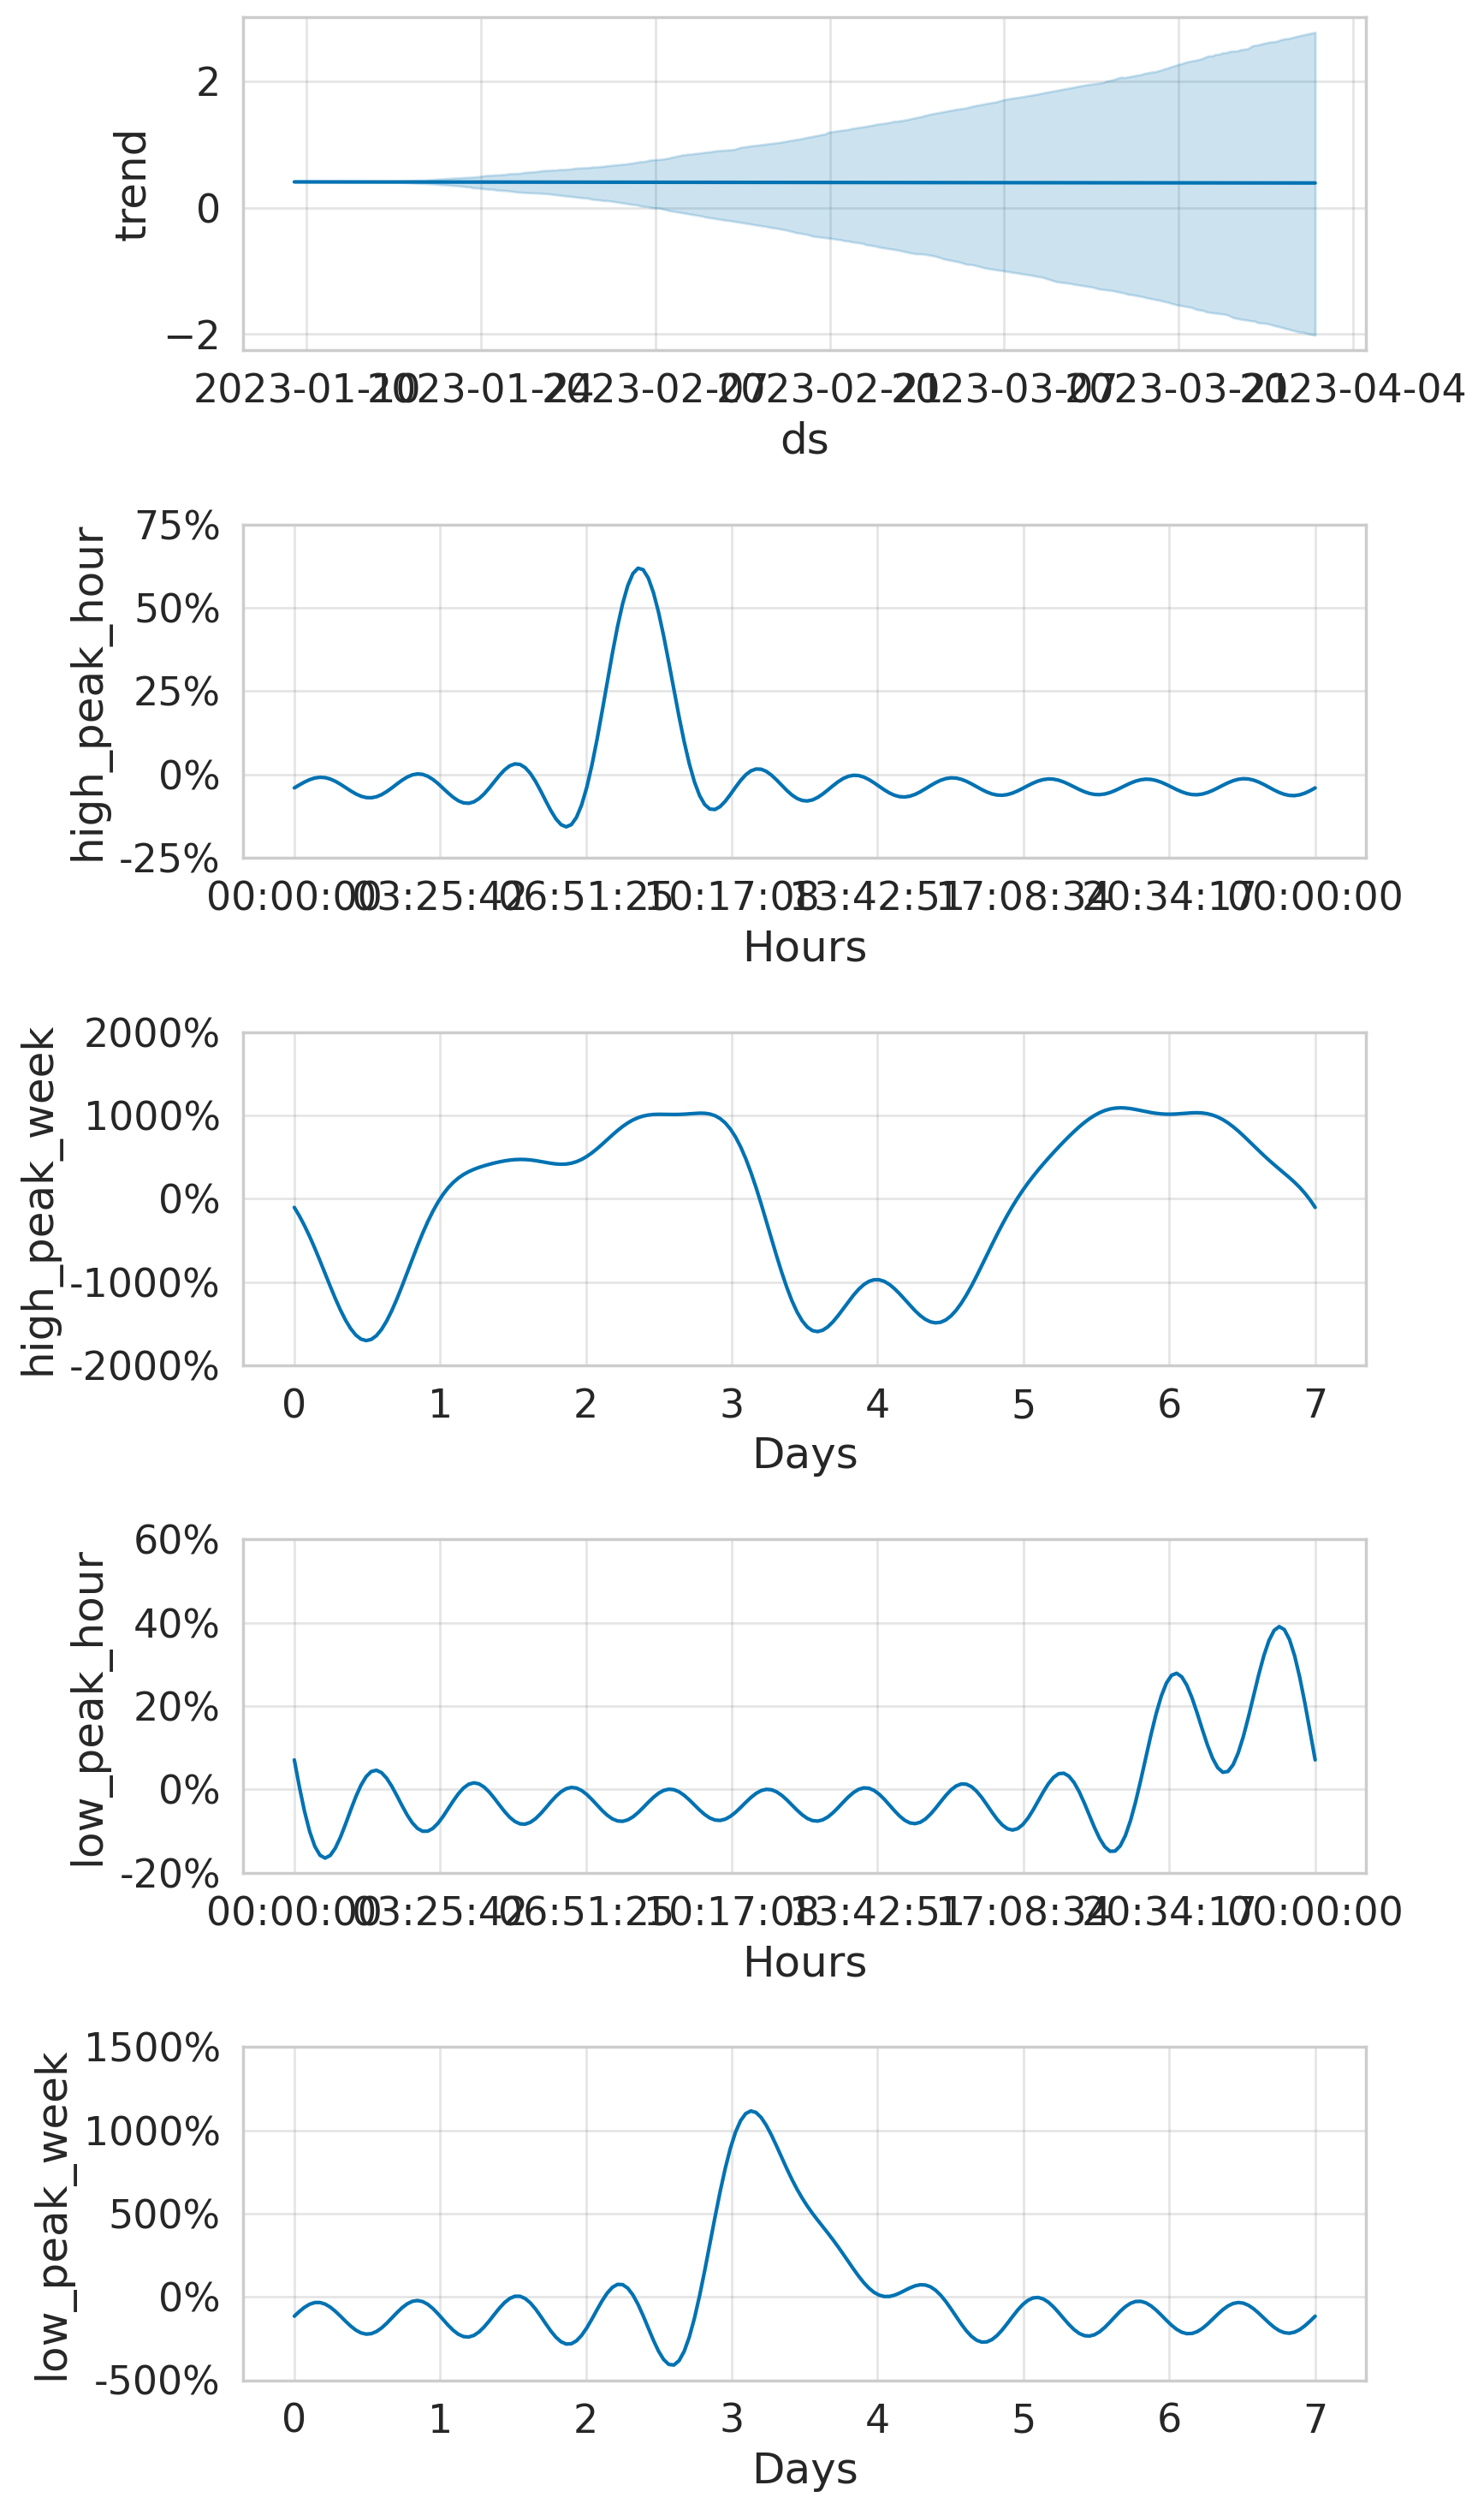

In [61]:
tr_df, te_df, df = get_train_test_generic(df_cliente6, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

m6 = Prophet(daily_seasonality = True, weekly_seasonality=True, yearly_seasonality=False, 
            changepoint_prior_scale = 0.1, seasonality_mode='multiplicative', seasonality_prior_scale = 1.0)
m6.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
m6.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
m6.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
m6.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
m6.fit(tr_df)
future6= m6.make_future_dataframe(periods=len(te_df), freq='h', include_history=False)
future6= generate_new_features(future6)
forecast6= m.predict(future6)
forecast6.index = forecast6.ds
plot_and_validate(tr_df, te_df, forecast6, 'y', 'yhat')
fig = m6.plot(forecast6, figsize=(14, 6))
display(forecast6.head())
m6.plot_components(forecast6);

## CLiente 17

In [62]:
def is_high_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Monday','Wednesday','Saturday', 'Sunday']

def is_low_peak_week(ds):
    date = pd.to_datetime(ds)
    day_name = date.day_name()
    return day_name in ['Thursday']

def is_low_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [0,1,2,3,21,22,23]

def is_high_peak_hour(ds):
    date = pd.to_datetime(ds)
    return date.hour in [4,5,6,7,8,9,10,11,12]

def generate_new_features(df):
    df['high_peak_week'] = df['ds'].apply(is_high_peak_week)
    df['low_peak_week'] = df['ds'].apply(is_low_peak_week)
    df['low_peak_hour'] = df['ds'].apply(is_low_peak_hour)
    df['high_peak_hour'] = df['ds'].apply(is_high_peak_hour)
    return df

In [20]:
tr_df, te_df, df = get_train_test_generic(df_cliente17, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

import time
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
start = time.time()
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'seasonality_mode': ['additive','multiplicative']
}

all_params = ParameterGrid(param_grid)
display(list(all_params))
mapes = []
rmses = []
for params in all_params:
    m = Prophet (yearly_seasonality = False,
                weekly_seasonality = params['weekly_seasonality'],
                daily_seasonality = params['daily_seasonality'],
                seasonality_mode = params['seasonality_mode'],
                changepoint_prior_scale = params['changepoint_prior_scale'],
                seasonality_prior_scale = params['seasonality_prior_scale']
                )
    m.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
    m.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
    m.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
    m.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
    m.fit(tr_df)
    cutoffs = pd.to_datetime(['2022-04-01','2022-08-01'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='10 days')
    df_p = performance_metrics(df_cv, rolling_window=5)
    print("mape = {}".format(df_p['mape'].iloc[0]))
    mapes.append(df_p['mape'].iloc[0])
    rmses.append(df_p['rmse'].iloc[0])
    print("Tiempo de ejecución = {}".format(params, time.time()- start))
    
#Encontrar los hiperparametros
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results['rmse'] = rmses
print(tuning_results)


#python
best_params = all_params[np.argmin(mapes)]
print(best_params)
print("Tiempo total = {}".format(time.time() - start))
display(tuning_results)
print(best_params)

[{'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 1.0,
  'weekly_seasonality': False},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': True},
 {'changepoint_prior_scale': 0.001,
  'daily_seasonality': True,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01,
  'weekly_seasonality': False

20:56:57 - cmdstanpy - INFO - Chain [1] start processing
20:57:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:57:03 - cmdstanpy - INFO - Chain [1] start processing
20:57:07 - cmdstanpy - INFO - Chain [1] done processing
20:57:10 - cmdstanpy - INFO - Chain [1] start processing
20:57:16 - cmdstanpy - INFO - Chain [1] done processing


mape = 14.897291815512736
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:57:20 - cmdstanpy - INFO - Chain [1] start processing
20:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:57:25 - cmdstanpy - INFO - Chain [1] start processing
20:57:28 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 16.12575370791278
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:57:39 - cmdstanpy - INFO - Chain [1] start processing
20:57:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:57:44 - cmdstanpy - INFO - Chain [1] start processing
20:57:48 - cmdstanpy - INFO - Chain [1] done processing
20:57:51 - cmdstanpy - INFO - Chain [1] start processing
20:57:54 - cmdstanpy - INFO - Chain [1] done processing


mape = 12.472815008869519
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:57:57 - cmdstanpy - INFO - Chain [1] start processing
20:58:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:08 - cmdstanpy - INFO - Chain [1] done processing
20:58:11 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing


mape = 10.66355722963699
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


20:58:18 - cmdstanpy - INFO - Chain [1] start processing
20:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:58:26 - cmdstanpy - INFO - Chain [1] start processing
20:58:29 - cmdstanpy - INFO - Chain [1] done processing
20:58:33 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing


mape = 25.459473911288246
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


20:58:40 - cmdstanpy - INFO - Chain [1] start processing
20:58:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:58:50 - cmdstanpy - INFO - Chain [1] start processing
20:58:53 - cmdstanpy - INFO - Chain [1] done processing
20:58:56 - cmdstanpy - INFO - Chain [1] start processing
20:58:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 25.30335703877814
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


20:59:02 - cmdstanpy - INFO - Chain [1] start processing
20:59:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:59:19 - cmdstanpy - INFO - Chain [1] start processing
20:59:25 - cmdstanpy - INFO - Chain [1] done processing
20:59:27 - cmdstanpy - INFO - Chain [1] start processing
20:59:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 8.534479930419746
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


20:59:38 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

20:59:52 - cmdstanpy - INFO - Chain [1] start processing
20:59:59 - cmdstanpy - INFO - Chain [1] done processing
21:00:02 - cmdstanpy - INFO - Chain [1] start processing
21:00:09 - cmdstanpy - INFO - Chain [1] done processing


mape = 6.418403659155562
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:00:18 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:23 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing


mape = 20.289914023154093
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:00:32 - cmdstanpy - INFO - Chain [1] start processing
21:00:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:00:37 - cmdstanpy - INFO - Chain [1] start processing
21:00:41 - cmdstanpy - INFO - Chain [1] done processing
21:00:43 - cmdstanpy - INFO - Chain [1] start processing
21:00:46 - cmdstanpy - INFO - Chain [1] done processing


mape = 20.640996843799194
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:01:01 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:10 - cmdstanpy - INFO - Chain [1] start processing
21:01:14 - cmdstanpy - INFO - Chain [1] done processing


mape = 15.783862100622622
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:01:17 - cmdstanpy - INFO - Chain [1] start processing
21:01:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:01:22 - cmdstanpy - INFO - Chain [1] start processing
21:01:26 - cmdstanpy - INFO - Chain [1] done processing
21:01:29 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing


mape = 15.706767332452353
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:01:38 - cmdstanpy - INFO - Chain [1] start processing
21:01:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:01:44 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing


mape = 30.258447959622455
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:07 - cmdstanpy - INFO - Chain [1] done processing
21:02:09 - cmdstanpy - INFO - Chain [1] start processing
21:02:15 - cmdstanpy - INFO - Chain [1] done processing


mape = 30.866074762460833
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:02:31 - cmdstanpy - INFO - Chain [1] start processing
21:02:37 - cmdstanpy - INFO - Chain [1] done processing
21:02:40 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing


mape = 11.233501359821444
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:06 - cmdstanpy - INFO - Chain [1] start processing
21:03:10 - cmdstanpy - INFO - Chain [1] done processing


mape = 10.674183968014777
Tiempo de ejecución = {'changepoint_prior_scale': 0.001, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:03:14 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing


mape = 22.752629965182237
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:03:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:04:02 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:09 - cmdstanpy - INFO - Chain [1] start processing
21:04:18 - cmdstanpy - INFO - Chain [1] done processing


mape = 22.750243588666354
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:04:22 - cmdstanpy - INFO - Chain [1] start processing
21:04:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:04:37 - cmdstanpy - INFO - Chain [1] start processing
21:04:43 - cmdstanpy - INFO - Chain [1] done processing
21:04:46 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing


mape = 25.347798626086572
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:05:11 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:30 - cmdstanpy - INFO - Chain [1] done processing


mape = 26.84363725966258
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:05:34 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:05:48 - cmdstanpy - INFO - Chain [1] start processing
21:05:51 - cmdstanpy - INFO - Chain [1] done processing
21:05:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.8379585589377476
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:25 - cmdstanpy - INFO - Chain [1] start processing
21:06:33 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.756147294258439
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:07:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:07:45 - cmdstanpy - INFO - Chain [1] start processing
21:07:50 - cmdstanpy - INFO - Chain [1] done processing
21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.940448921001905
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:09:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:25 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.483981374827679
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:10:23 - cmdstanpy - INFO - Chain [1] start processing
21:10:32 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:46 - cmdstanpy - INFO - Chain [1] done processing


mape = 18.16914446490041
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:11:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:13 - cmdstanpy - INFO - Chain [1] start processing
21:11:20 - cmdstanpy - INFO - Chain [1] done processing


mape = 18.17760045827503
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:11:23 - cmdstanpy - INFO - Chain [1] start processing
21:11:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:11:38 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1] done processing


mape = 24.931323642547294
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:12:00 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:12:10 - cmdstanpy - INFO - Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] done processing
21:12:18 - cmdstanpy - INFO - Chain [1] start processing
21:12:28 - cmdstanpy - INFO - Chain [1] done processing


mape = 21.705439739802213
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:12:32 - cmdstanpy - INFO - Chain [1] start processing
21:12:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:48 - cmdstanpy - INFO - Chain [1] done processing
21:12:51 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.4144817274151884
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:13:01 - cmdstanpy - INFO - Chain [1] start processing
21:13:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:13:11 - cmdstanpy - INFO - Chain [1] start processing
21:13:14 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:22 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.359385253214226
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:13:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:14:14 - cmdstanpy - INFO - Chain [1] start processing
21:14:24 - cmdstanpy - INFO - Chain [1] done processing
21:14:27 - cmdstanpy - INFO - Chain [1] start processing
21:14:54 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.1990349788269805
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:14:57 - cmdstanpy - INFO - Chain [1] start processing
21:15:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:15:10 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:16 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.7144158472191748
Tiempo de ejecución = {'changepoint_prior_scale': 0.01, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:16:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:24 - cmdstanpy - INFO - Chain [1] done processing
21:16:27 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing


mape = 26.438519992292672
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:16:54 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:17:30 - cmdstanpy - INFO - Chain [1] start processing
21:17:46 - cmdstanpy - INFO - Chain [1] done processing
21:17:49 - cmdstanpy - INFO - Chain [1] start processing
21:18:09 - cmdstanpy - INFO - Chain [1] done processing


mape = 26.58122515456442
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing


mape = 29.204333743761588
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:19:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing


mape = 29.85701643095664
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:21:42 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.6107098087388265
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.9038946656471623
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:17 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.6731379983144334
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:26:44 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:28:05 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.4820648721385594
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:28:09 - cmdstanpy - INFO - Chain [1] start processing
21:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:28:44 - cmdstanpy - INFO - Chain [1] start processing
21:28:56 - cmdstanpy - INFO - Chain [1] done processing
21:28:59 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing


mape = 23.35054669147736
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:29:19 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:29:58 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:14 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1] done processing


mape = 22.398804638207544
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:30:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:31:14 - cmdstanpy - INFO - Chain [1] start processing
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:59 - cmdstanpy - INFO - Chain [1] done processing


mape = 29.053793261225703
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:32:03 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:32:34 - cmdstanpy - INFO - Chain [1] start processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing


mape = 26.420554251620366
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}


21:33:18 - cmdstanpy - INFO - Chain [1] start processing
21:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:34:10 - cmdstanpy - INFO - Chain [1] done processing
21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing


mape = 3.4677146380995705
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


21:34:31 - cmdstanpy - INFO - Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:35:05 - cmdstanpy - INFO - Chain [1] start processing
21:35:18 - cmdstanpy - INFO - Chain [1] done processing
21:35:21 - cmdstanpy - INFO - Chain [1] start processing
21:35:37 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.2464515325001546
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': False}


21:35:40 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:36:35 - cmdstanpy - INFO - Chain [1] start processing
21:36:56 - cmdstanpy - INFO - Chain [1] done processing
21:36:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:33 - cmdstanpy - INFO - Chain [1] done processing


mape = 2.6321855117011568
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True}


21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing


mape = 1.766213074849694
Tiempo de ejecución = {'changepoint_prior_scale': 0.1, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': False}
    changepoint_prior_scale  daily_seasonality seasonality_mode  \
0                     0.001               True         additive   
1                     0.001               True         additive   
2                     0.001               True         additive   
3                     0.001               True         additive   
4                     0.001               True   multiplicative   
5                     0.001               True   multiplicative   
6                     0.001               True   multiplicative   
7                     0.001               True   multiplicative   
8                     0.001              False         additive   
9                     0.001              False         additive   
10                    0.001              False         a

/tmp/ipykernel_34/3913918911.py:50: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  best_params = all_params[np.argmin(mapes)]


,changepoint_prior_scale,daily_seasonality,seasonality_mode,seasonality_prior_scale,weekly_seasonality,mape,rmse
0,0.001,True,additive,0.01,True,14.897292,0.891036
1,0.001,True,additive,0.01,False,16.125754,0.909247
2,0.001,True,additive,1.00,True,12.472815,0.946735
3,0.001,True,additive,1.00,False,10.663557,0.946664
4,0.001,True,multiplicative,0.01,True,25.459474,0.601979
5,0.001,True,multiplicative,0.01,False,25.303357,0.590212
6,0.001,True,multiplicative,1.00,True,8.534480,0.498842
7,0.001,True,multiplicative,1.00,False,6.418404,0.502343
8,0.001,False,additive,0.01,True,20.289914,0.868392
9,0.001,False,additive,0.01,False,20.640997,0.879679


{'weekly_seasonality': False, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'daily_seasonality': False, 'changepoint_prior_scale': 0.01}


22:20:28 - cmdstanpy - INFO - Chain [1] start processing
22:20:39 - cmdstanpy - INFO - Chain [1] done processing


mse=0.122, rmse=0.349, mae=0.282, mape=1.656, smape=0.736


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,high_peak_hour,high_peak_hour_lower,high_peak_hour_upper,high_peak_week,high_peak_week_lower,high_peak_week_upper,low_peak_hour,low_peak_hour_lower,low_peak_hour_upper,low_peak_week,low_peak_week_lower,low_peak_week_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01 19:00:00,2023-01-01 19:00:00,0.373476,-0.873093,1.830261,0.373476,0.373476,0.0,0.0,0.0,0.115299,0.115299,0.115299,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.115299,0.115299,0.115299,0.0,0.0,0.0,0.416538
2023-01-01 20:00:00,2023-01-01 20:00:00,0.373463,-0.846434,1.775627,0.373463,0.373463,0.0,0.0,0.0,0.075726,0.075726,0.075726,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.075726,0.075726,0.075726,0.0,0.0,0.0,0.401744
2023-01-01 21:00:00,2023-01-01 21:00:00,0.373449,-1.089510,1.578536,0.373449,0.373449,0.0,0.0,0.0,0.032819,0.032819,0.032819,-0.463881,-0.463881,-0.463881,0.0,0.0,0.0,-0.431062,-0.431062,-0.431062,0.0,0.0,0.0,0.212469
2023-01-01 22:00:00,2023-01-01 22:00:00,0.373435,-1.370993,1.433831,0.373435,0.373435,0.0,0.0,0.0,-0.010224,-0.010224,-0.010224,-0.858157,-0.858157,-0.858157,0.0,0.0,0.0,-0.868381,-0.868381,-0.868381,0.0,0.0,0.0,0.049151
2023-01-01 23:00:00,2023-01-01 23:00:00,0.373422,-1.245487,1.461663,0.373422,0.373422,0.0,0.0,0.0,-0.049741,-0.049741,-0.049741,-0.837199,-0.837199,-0.837199,0.0,0.0,0.0,-0.886940,-0.886940,-0.886940,0.0,0.0,0.0,0.042219


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

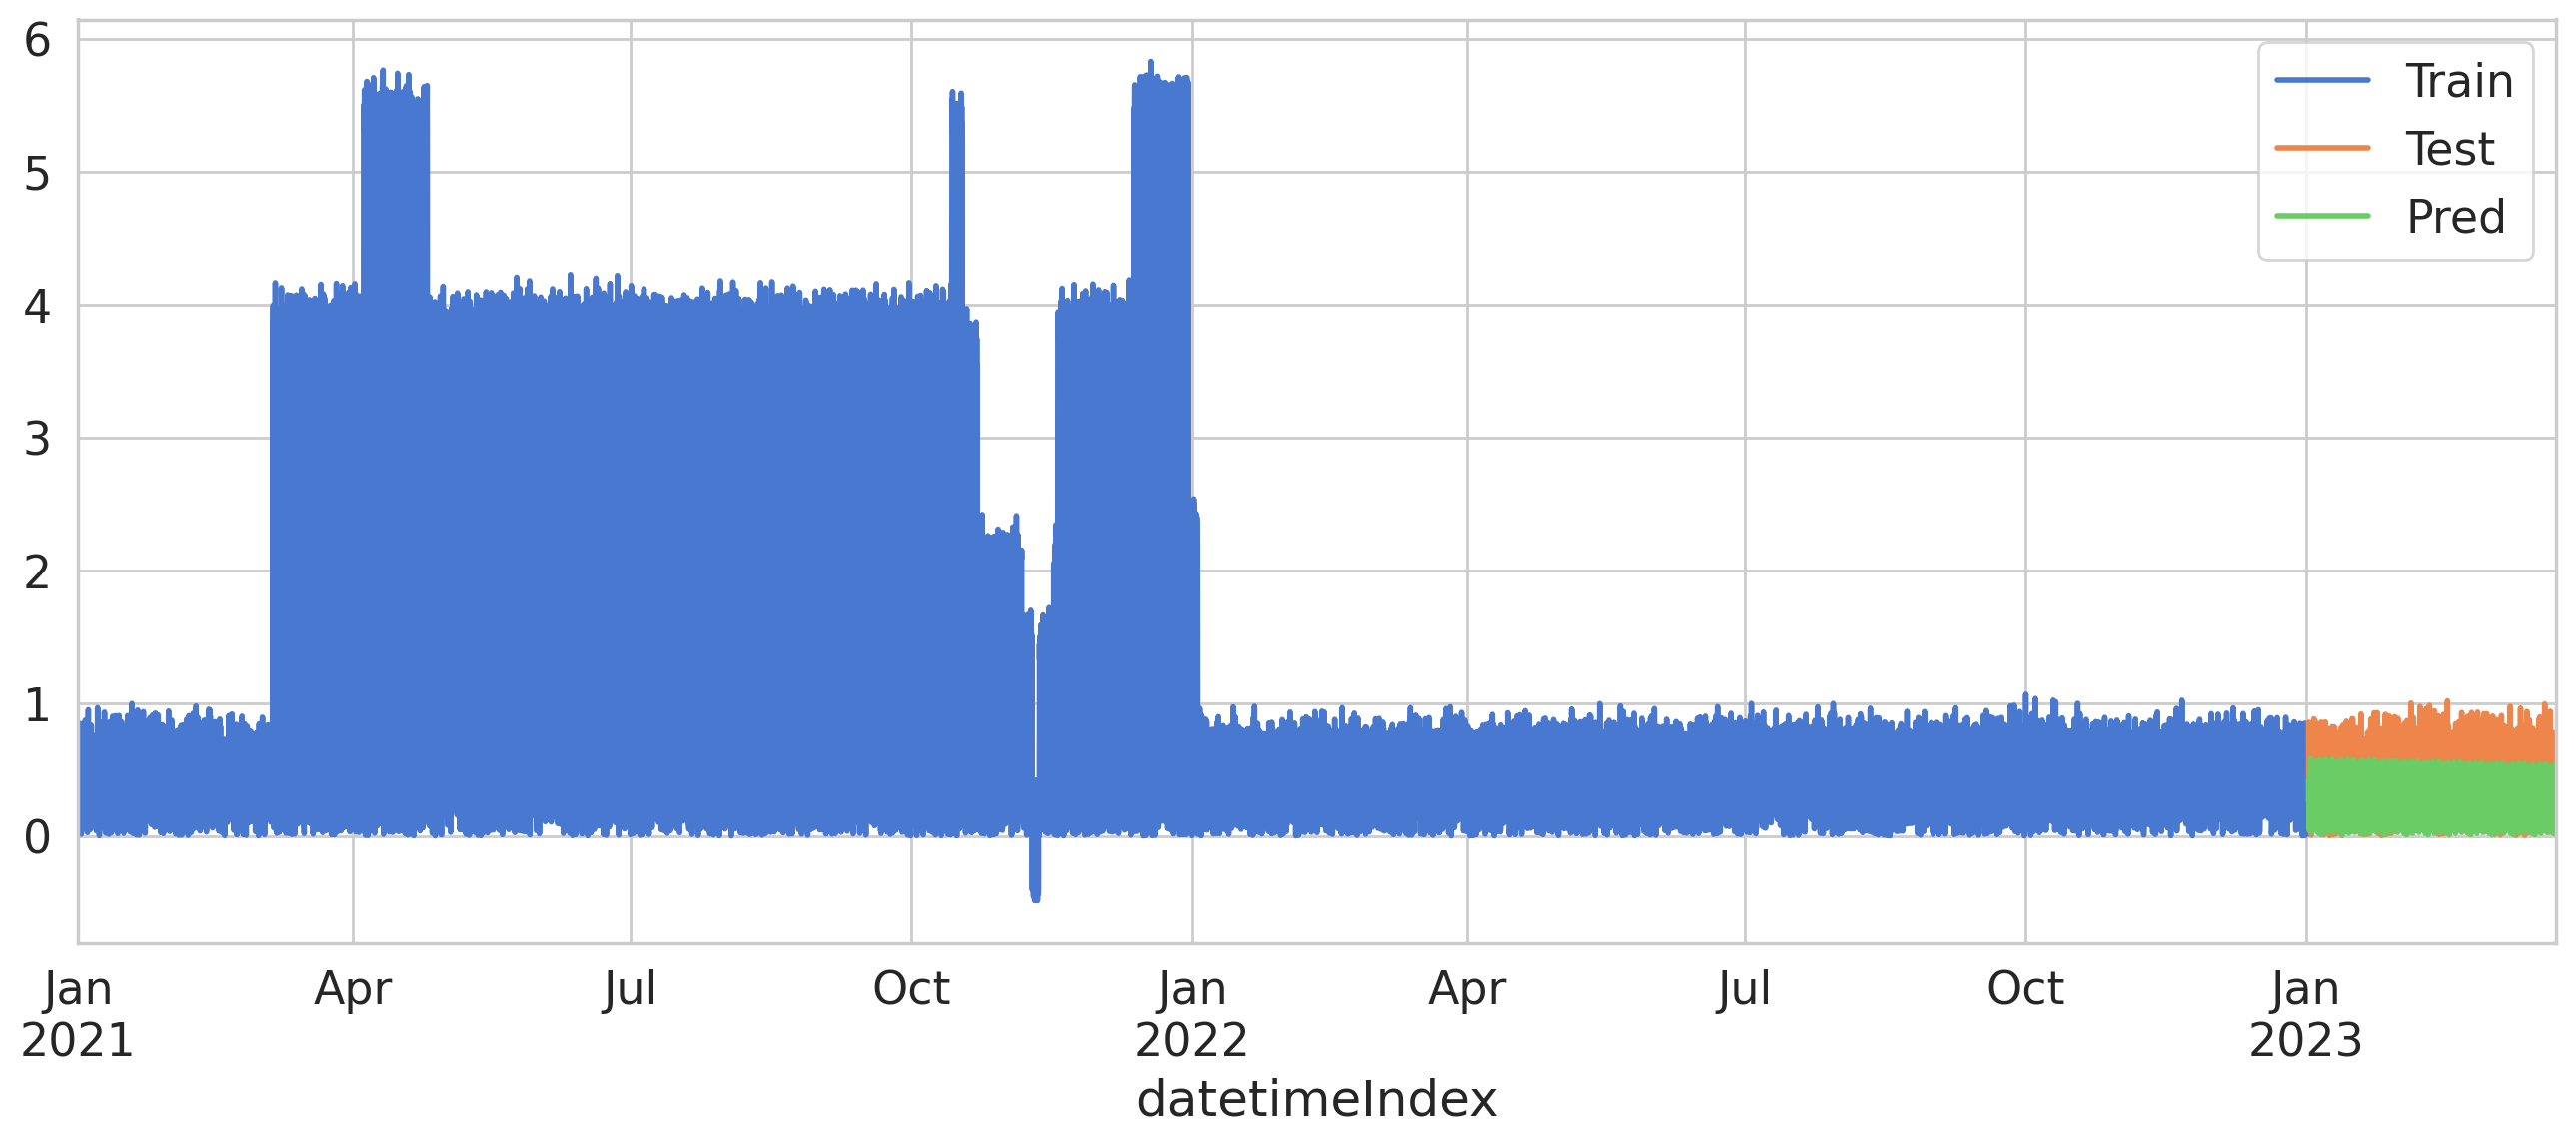

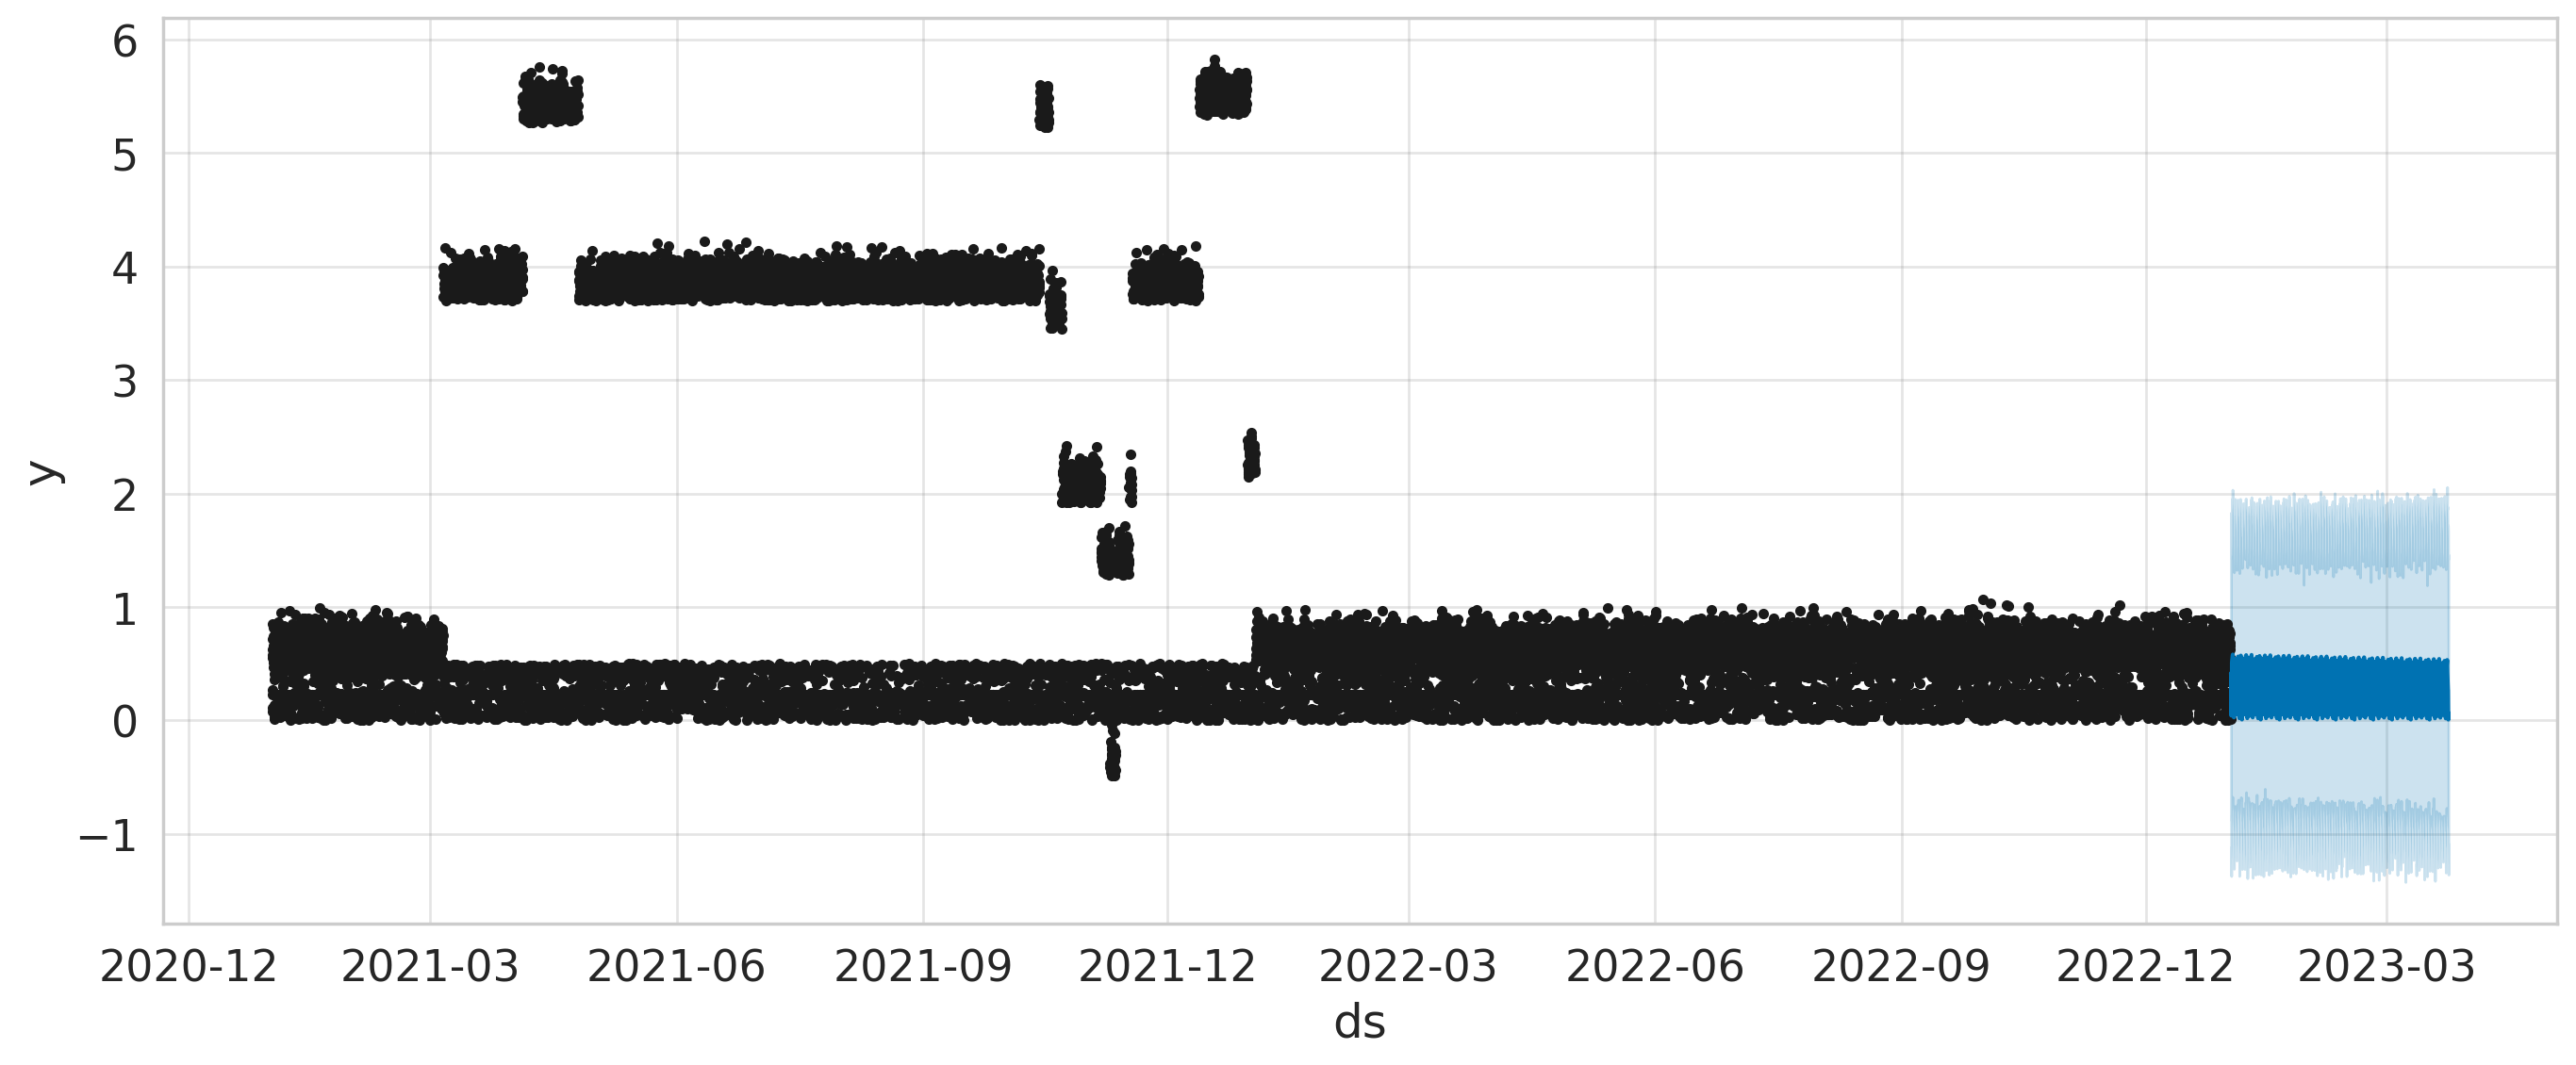

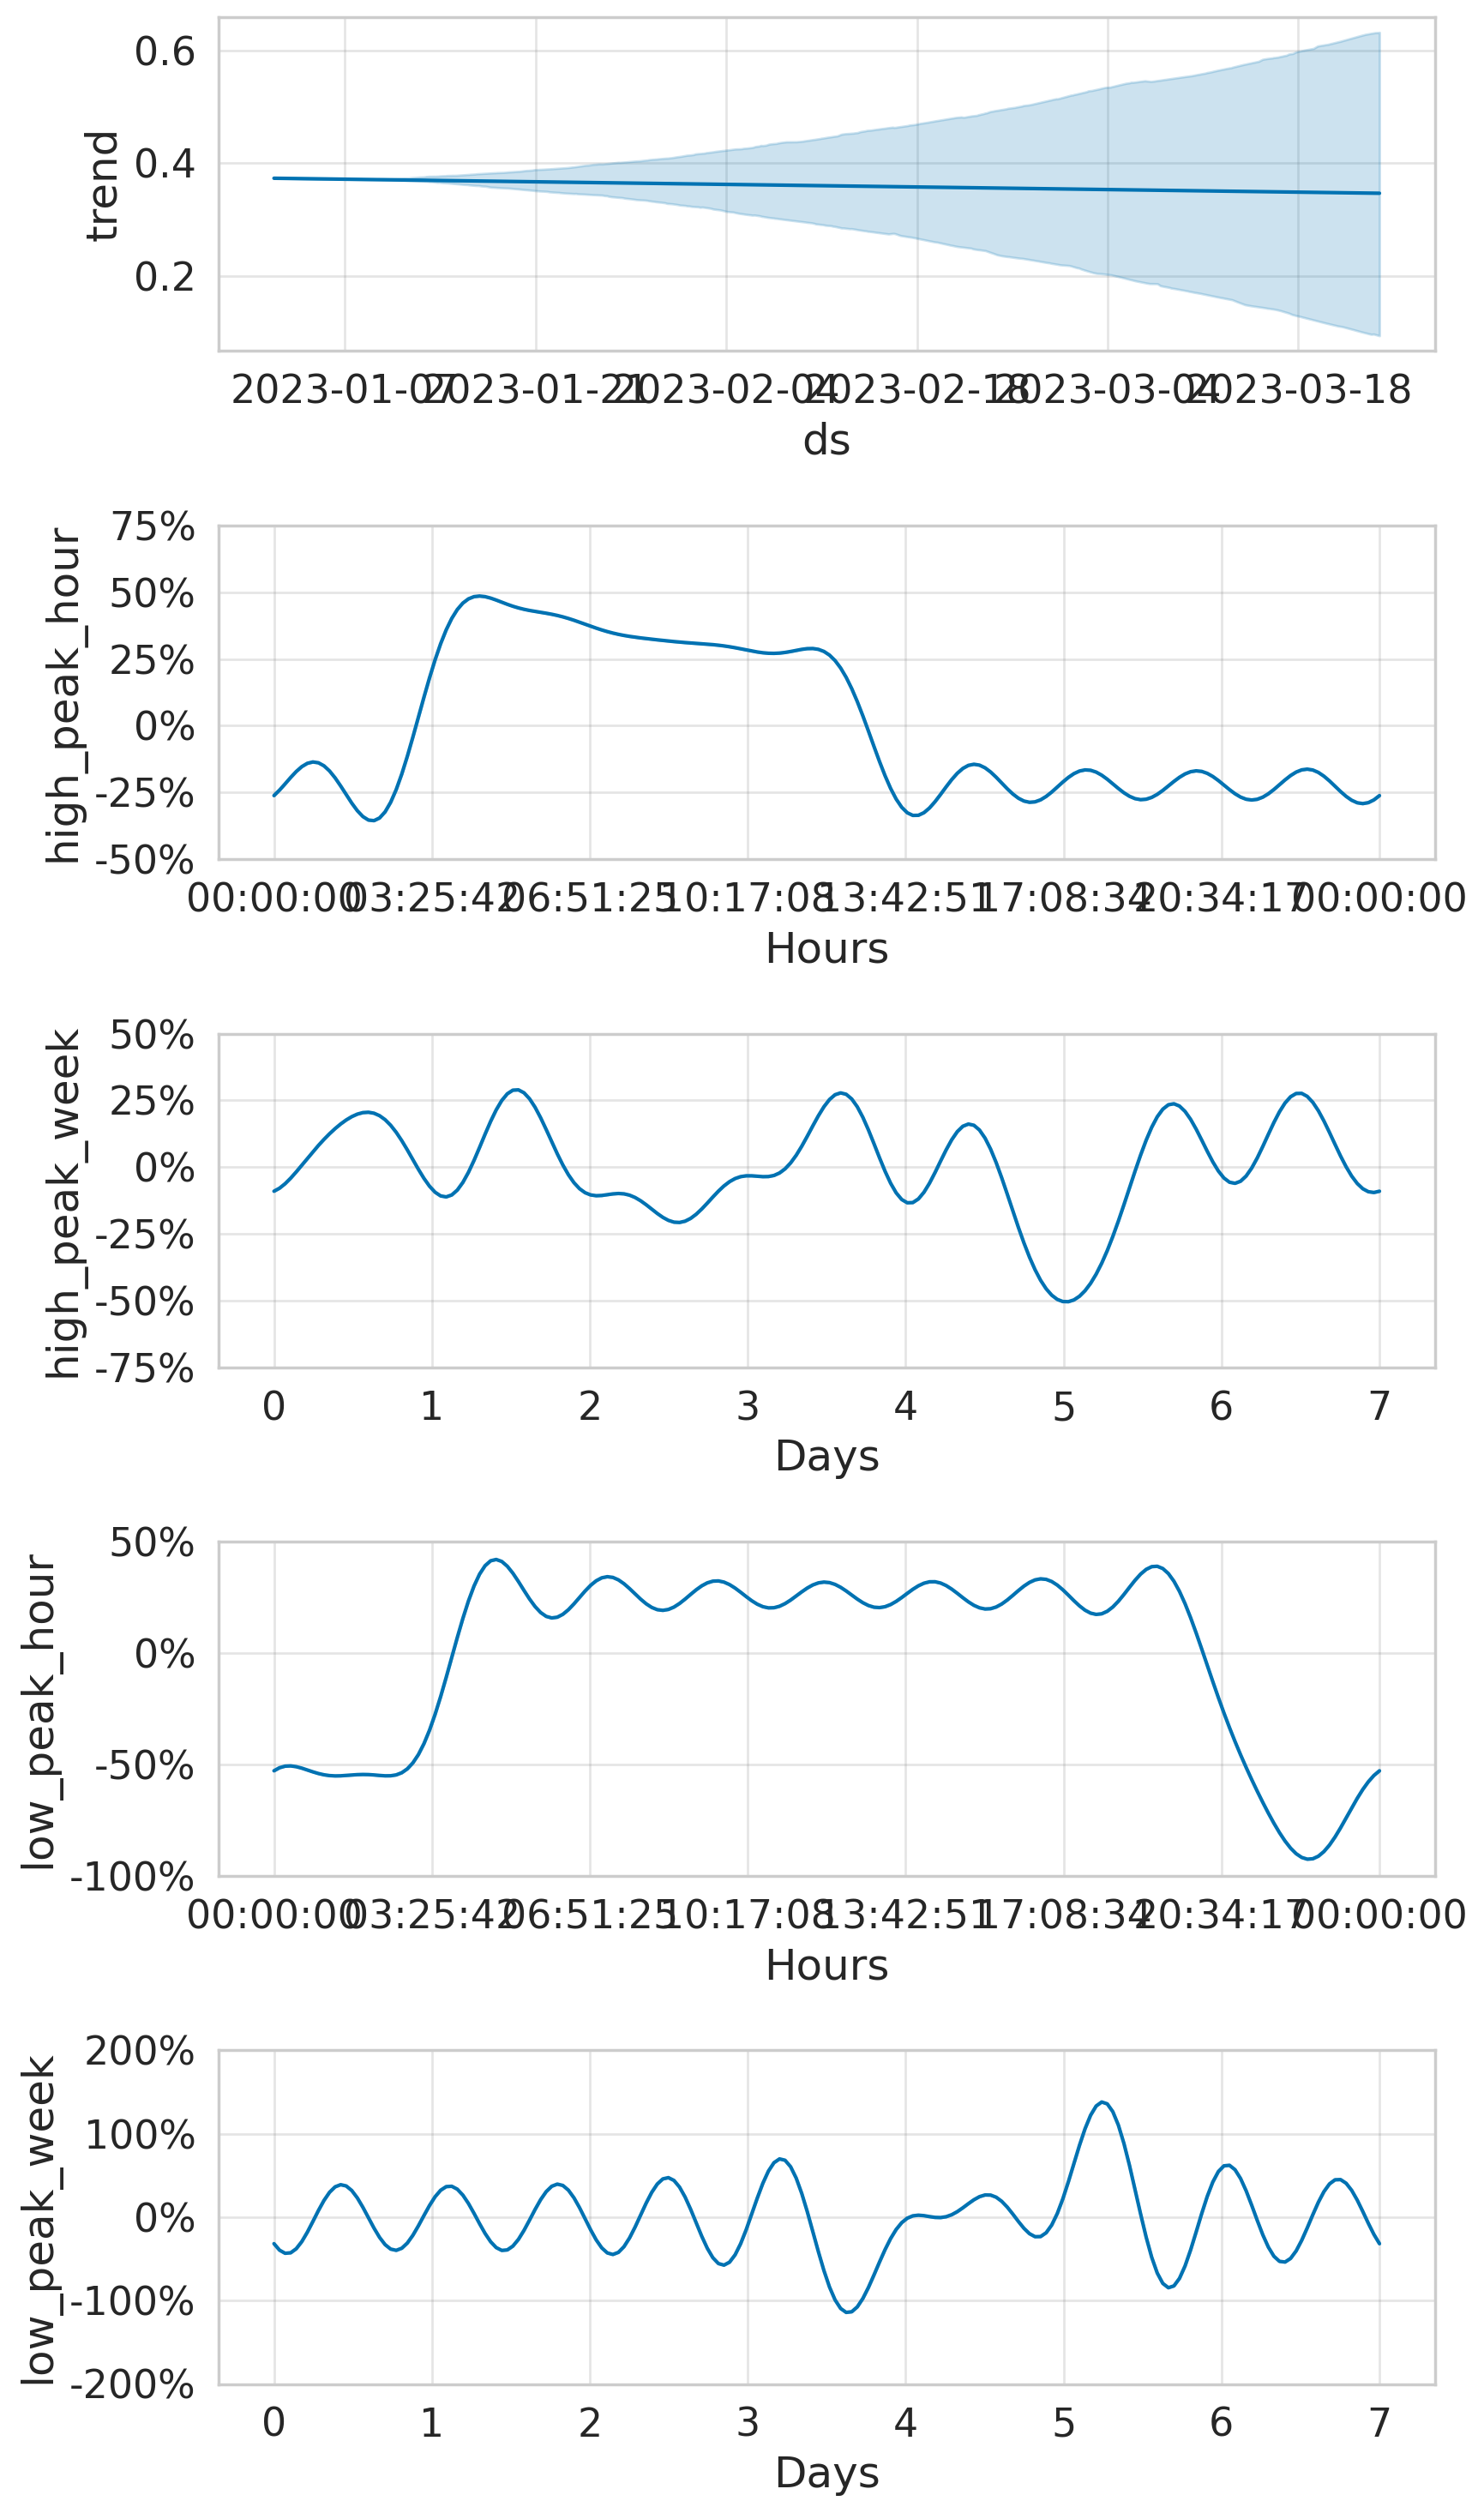

In [63]:
tr_df, te_df, df = get_train_test_generic(df_cliente17, for_prophet=True, freq=None)
tr_df = generate_new_features(tr_df)
te_df = generate_new_features(te_df)

m17 = Prophet(daily_seasonality = False, weekly_seasonality=False, yearly_seasonality=False, 
            changepoint_prior_scale = 0.01, seasonality_mode='multiplicative', seasonality_prior_scale = 1.0)
m17.add_seasonality(name='low_peak_week', period=7, fourier_order=10, condition_name = 'low_peak_week')
m17.add_seasonality(name='high_peak_week', period=7, fourier_order=10, condition_name = 'high_peak_week')
m17.add_seasonality(name='low_peak_hour', period=1, fourier_order=10, condition_name = 'low_peak_hour')
m17.add_seasonality(name='high_peak_hour', period=1, fourier_order=10, condition_name = 'high_peak_hour')
m17.fit(tr_df)
future17= m17.make_future_dataframe(periods=len(te_df), freq='h', include_history=False)
future17= generate_new_features(future17)
forecast17= m17.predict(future17)
forecast17.index = forecast17.ds
plot_and_validate(tr_df, te_df, forecast17, 'y', 'yhat')
fig = m17.plot(forecast17, figsize=(14, 6))
display(forecast17.head())
m17.plot_components(forecast17);

In [65]:
import joblib
# Guarda el modelo en un archivo
joblib.dump(m1,"prophet_model1.pkl")
joblib.dump(m6, "prophet_model6.pkl")
joblib.dump(m17, "prophet_model17.pkl")

['prophet_model17.pkl']